<a href="https://colab.research.google.com/github/Toto17515/KKU_Project/blob/Data/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import

##Library

In [ ]:
#Basic
import math
import decimal
import statsmodels
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.dates as mpdates
import statsmodels.api as sm
import matplotlib.gridspec as gridspec
from itertools import combinations
from math import isnan, nan
from datetime import datetime 
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#Candel
!pip install mpl_finance 
from mpl_finance import candlestick_ohlc

##Data

In [ ]:
EURUSD = pd.read_csv('https://raw.githubusercontent.com/Toto17515/KKU_Project/Data/EURUSD.csv')
EURUSD['Date'] = pd.to_datetime(EURUSD['Date'],format ='%d/%m/%Y', errors='raise')
XAUUSD = pd.read_csv('https://raw.githubusercontent.com/Toto17515/KKU_Project/Data/XAUUSD.csv')
XAUUSD['Date'] = pd.to_datetime(XAUUSD['Date'],format ='%d/%m/%Y', errors='raise')
WTIUSD = pd.read_csv('https://raw.githubusercontent.com/Toto17515/KKU_Project/Data/WTIUSD.csv')
WTIUSD['Date'] = pd.to_datetime(WTIUSD['Date'],format ='%d/%m/%Y', errors='raise')
SPX = pd.read_csv('https://raw.githubusercontent.com/Toto17515/KKU_Project/Data/SPX.csv')
SPX['Date'] = pd.to_datetime(SPX['Date'],format ='%d/%m/%Y', errors='raise')
STOXX = pd.read_csv('https://raw.githubusercontent.com/Toto17515/KKU_Project/Data/STOXX.csv')
STOXX['Date'] = pd.to_datetime(STOXX['Date'],format ='%d/%m/%Y', errors='raise')

#Parameter

##Maximize

In [ ]:
#EMA Indicator
def EMAIndicator(Close, A):
  if A > 1 and len(Close) > 1:
    EMA = []
    for a in range(A-1):
      EMA.append(float('NaN'))
    alpha = 2/(A+1)
    ws = 0
    wc = 0
    for b in range(A):
      ws = ws + Close[b]*(1-alpha)**b
      wc = wc + (1-alpha)**b
    EMA.append(ws/wc)
    for c in range(len(Close)-A):
      EMA.append(EMA[c+A-1]+alpha*(Close[c+A]-EMA[c+A-1]))
    return EMA
  else:
    return print('error')  

In [ ]:
#PSAR Indicator
def PSARIndicator(High, Low):
  sar = [float('NaN'),float('NaN')]
  psar_trend = ['Sideway', 'Sideway']
  direction = 'None'; h = 0; k = 0; d = 2; AF = 0.02
  if len(High) == len(Low) and len(High)> 2:
    #Begin
    for i in range(len(High)-1):
      if (High[i+1] > High[i] and Low[i+1] < Low[i]) or (High[i+1] < High[i] and Low[i+1] > Low[i]):
        direction = 'Sideway'
        psar_trend.append('Sideway')  
        sar.append(float('NaN'))
        d += 1
      elif  High[i+1] > High[i]:
        direction = 'Up'
        h = max(High[:i+d+1])
        sar.append(min(Low[:i+1])); break
      else:
        direction = 'Down'
        l = min(Low[:i+d+1])
        sar.append(max(High[:i+1])); break
    #PSAR
    for j in range(len(High)-d):
      if direction == 'Up':
        psar = sar[j+d]+AF*(h-sar[j+d])
        if Low[j+d] > psar: 
          sar.append(psar)
          psar_trend.append('Up')
          direction = 'Up'
          if j < len(High)-d-1:
            if h < High[j+d+1]: 
              h = High[j+d+1]
              if AF <= 0.20: AF += 0.02
        else: 
          sar.append(h)
          psar_trend.append('Down')
          direction = 'Down'
          AF = 0.02
          if j < len(High)-d-1: l = Low[j+d+1]
      else:
        psar = sar[j+d]-AF*(sar[j+d]-l)
        if High[j+d] < psar: 
          sar.append(psar)
          psar_trend.append('Down')
          direction = 'Down'
          if j < len(Low)-d-1:
            if l > Low[j+d+1]: 
              l = Low[j+d+1]
              if AF <= 0.20: AF += 0.02
        else: 
          sar.append(l)
          psar_trend.append('Up')
          direction = 'Up'
          AF = 0.02   
          if j < len(Low)-d-1: h = High[j+d+1]     
    return psar_trend
  else:
    return print('error')  

In [ ]:
#RSI Indicator
def RSIIndicator(Close, B):
  Diff = []; Up = []; Down = []; 
  UpAVG = []; DownAVG = []; RSI = []; 
  for a in range(B):
    RSI.append(float('NaN'))
  for i in range(len(Close)):
    if i > 0: Diff.append(Close[i]-Close[i-1])
  for j in range(len(Diff)):
    if Diff[j] > 0:
      Up.append(Diff[j])
      Down.append(0)
    elif Diff[j] < 0:
      Up.append(0)
      Down.append(-Diff[j])
    else:
      Up.append(0)
      Down.append(0)
  UpAVG.append(sum(Up[:B])/len(Up[:B]))
  DownAVG.append(sum(Down[:B])/len(Down[:B]))
  for k in range(len(Diff)-B):
    UpAVG.append((UpAVG[k]*(B-1)+Up[k+B])/B)
    DownAVG.append((DownAVG[k]*(B-1)+Down[k+B])/B)
  for l in range(len(UpAVG)):
    RSI.append(100-100/(1+(UpAVG[l]/DownAVG[l])))
  return RSI

In [ ]:
#WPR Indicator
def WPRIndicator(High, Low, Close, C):
  WPR = []; 
  for a in range(C-1):
     WPR.append(float('NaN'))
  for i in range(len(Close)):
    if i >= C-1: 
      Highest = max(High[i-C+1:i+1]) 
      Lowest = min(Low[i-C+1:i+1])
      WPR.append((Close[i]-Highest)/(Highest-Lowest)*100)
  return WPR

In [ ]:
#logic #ปรับ
def parameter(Y1, Y2, Y3, A, B, C):
  Trend = []
  ema = EMAIndicator(Y3, A); ema_trend = []
  for i in range(len(ema)):
    if Y3[i] > ema[i]: ema_trend.append('Up')
    elif Y3[i] < ema[i]: ema_trend.append('Down')
    else: ema_trend.append('Sideway')
  psar_trend = PSARIndicator(Y1, Y2)
  rsi = RSIIndicator(Y3, B); rsi_trend = []
  for j in range(len(rsi)):
    if rsi[i] > 50 : rsi_trend.append('Up')
    elif rsi[j] < 50: rsi_trend.append('Down')
    else: rsi_trend.append('Sideway')
  wpr = WPRIndicator(Y1, Y2, Y3, C); wpr_trend = []
  for k in range(len(wpr)):
    if wpr[k] > -50: wpr_trend.append('Up')
    elif wpr[k] < -50: wpr_trend.append('Down')
    else: wpr_trend.append('Sideway')
  for l in range(len(Y3)):
    if ema_trend[l] == psar_trend[l] == rsi_trend[l] == wpr_trend[l]: 
      Trend.append(ema_trend[l])
    else: Trend.append('Sideway')
  Real = ['Sideway']
  for m in range(len(Y3)):
    if m > 0:
      if Y3[m] > Y3[m-1]:
        Real.append('Up')
      elif Y3[m] < Y3[m-1]:
        Real.append('Down')
      else:
        Real.append('Sideway')
  T = 0; N = 0
  for n in range(len(Trend)):
    if Trend[n] != 'Sideway':
      N+=1
      if Real[n] == Trend[n]: T+=1
  if N == 0: return 0
  else: return T/N*100

In [ ]:
def Maximize(FOREX_High, FOREX_Low,FOREX_Close, listA, listB, listC):
  MAX = {}
  Y1 = FOREX_High.values.tolist(); Y2 = FOREX_Low.values.tolist(); Y3 = FOREX_Close.values.tolist()
  for a in listA:
    text1 = str('Parameter values ')
    text2 = str(', A = ') + str(a)
    for b in listB:
      text3 = str(', B = ') + str(b)
      for c in listC: 
        text4 = str(' and C = ') + str(c)
        precision = parameter(Y1, Y2, Y3, a, b, c)
        text5 = str(' give a maximum precision of ') + str(precision) + str(' %.')
        MAX[precision] = text1+text2+text3+text4+text5
  return print(MAX[max(MAX.keys())])                   

##Find

เลือกหาค่าพารามิเตอร์จากข้อมูลตั้งแต่ 01/01/2015 ถึง 31/12/2020



In [ ]:
EURUSD[EURUSD['Date'] <= datetime(2020,12,31)]['Date'].count()

1566

In [ ]:
#Set the variables
list_A = list(np.arange(5,21,5))
list_B = list(np.arange(5,21,5))
list_C = list(np.arange(5,21,5))
print('A = ', list_A, 'B = ', list_B, 'C = ', list_C)

A =  [5, 10, 15, 20] B =  [5, 10, 15, 20] C =  [5, 10, 15, 20]


In [ ]:
#Set 
Maximize(EURUSD['High'][:1567], EURUSD['Low'][:1567], EURUSD['Close'][:1567], list_A, list_B, list_C)

Parameter values , A = 5, B = 20 and C = 20 give a maximum precision of 69.93464052287581 %.



#Algorithm

##Sub Function

###Indicator

In [ ]:
#EMA
def EMA(Close, A):
  Close = Close.tolist()
  if len(Close) > A-1:
    EMA = []; ws = 0; wc = 0
    for a in range(A-1):
      EMA.append(float('NaN'))
    alpha = 2/(A+1)
    for b in range(A):
      ws = ws + Close[b]*(1-alpha)**b
      wc = wc + (1-alpha)**b
    EMA.append(ws/wc)
    for c in range(len(Close)-A):
      EMA.append(EMA[c+A-1]+alpha*(Close[c+A]-EMA[c+A-1]))
    if Close[len(Close)-1] > EMA[-1]: return 'Up'
    elif Close[len(Close)-1] < EMA[-1]: return 'Down'
    else: return 'Sideway'

In [ ]:
#PSAR
def PSAR(High, Low):
  High = High.tolist()
  Low = Low.tolist()
  sar = [float('NaN'),float('NaN')]
  direction = 'None'; h = 0; k = 0; d = 2; AF = 0.02
  if len(High) == len(Low) and len(High)> 2:
    #Begin
    for i in range(len(High)-1):
      if (High[i+1] > High[i] and Low[i+1] < Low[i]) or (High[i+1] < High[i] and Low[i+1] > Low[i]):
        direction = 'Sideway'
        sar.append(float('NaN'))
        d += 1
      elif  High[i+1] > High[i]:
        direction = 'Up'
        h = max(High[:i+d+1])
        sar.append(min(Low[:i+1])); break
      else:
        direction = 'Down'
        l = min(Low[:i+d+1])
        sar.append(max(High[:i+1])); break
    #PSAR
    for j in range(len(High)-d):
      if direction == 'Up':
        psar = sar[j+d]+AF*(h-sar[j+d])
        if Low[j+d] > psar: 
          sar.append(psar)
          psar_trend = 'Up'
          direction = 'Up'
          if j < len(High)-d-1:
            if h < High[j+d+1]: 
              h = High[j+d+1]
              if AF <= 0.20: AF += 0.02
        else: 
          sar.append(h)
          psar_trend = 'Down'
          direction = 'Down'
          AF = 0.02
          if j < len(High)-d-1: l = Low[j+d+1]
      else:
        psar = sar[j+d]-AF*(sar[j+d]-l)
        if High[j+d] < psar: 
          sar.append(psar)
          psar_trend = 'Down'
          direction = 'Down'
          if j < len(Low)-d-1:
            if l > Low[j+d+1]: 
              l = Low[j+d+1]
              if AF <= 0.20: AF += 0.02
        else: 
          sar.append(l)
          psar_trend ='Up'
          direction = 'Up'
          AF = 0.02   
          if j < len(Low)-d-1: h = High[j+d+1]     
    return psar_trend

In [ ]:
#RSI
def RSI(Close, B):
  Close = Close.tolist()
  Diff = []; Up = []; Down = []; 
  UpAVG = []; DownAVG = []; RSI = []; 
  for a in range(B):
    RSI.append(float('NaN'))
  for i in range(len(Close)):
    if i > 0: Diff.append(Close[i]-Close[i-1])
  for j in range(len(Diff)):
    if Diff[j] > 0:
      Up.append(Diff[j])
      Down.append(0)
    elif Diff[j] < 0:
      Up.append(0)
      Down.append(-Diff[j])
    else:
      Up.append(0)
      Down.append(0)
  UpAVG.append(sum(Up[:B])/len(Up[:B]))
  DownAVG.append(sum(Down[:B])/len(Down[:B]))
  for k in range(len(Diff)-B):
    UpAVG.append((UpAVG[k]*(B-1)+Up[k+B])/B)
    DownAVG.append((DownAVG[k]*(B-1)+Down[k+B])/B)
  for l in range(len(UpAVG)):
    if DownAVG[l] != 0:
      RSI.append(100-100/(1+(UpAVG[l]/DownAVG[l])))
    else: RSI.append(100)
  if RSI[-1] > 50: return 'Up'
  elif RSI[-1] < 50: return 'Down'
  else: return 'Sideway'

In [ ]:
#WPR
def WPR(High, Low, Close, C):
  High = High.tolist()
  Low = Low.tolist()
  Close = Close.tolist()
  Highest = max(High[-C:]) 
  Lowest = min(Low[-C:])
  WPR= (Close[len(Close)-1]-Highest)/(Highest-Lowest)*100
  if WPR > -50: return 'Up'
  elif WPR < -50: return 'Down'
  else: return 'Sideway' 

###Seasonal

In [ ]:
#ความยาวฤดูกาล
def Length_Seasonal(data, freq):
  SeasonalDecompose = statsmodels.tsa.seasonal.seasonal_decompose(data, freq=freq).seasonal
  LowSeasonal = []
  for i in SeasonalDecompose:
    if i <= min(SeasonalDecompose)+(max(SeasonalDecompose)-min(SeasonalDecompose))/5:
      LowSeasonal.append(i)
    else: LowSeasonal.append(float('NaN'))
  MinSeasonal = []
  MIN = {}
  for i in range(len(LowSeasonal)):
    if not isnan(LowSeasonal[i]): MIN[LowSeasonal[i]] = i+1
    else:
        if MIN:
          MinSeasonal.append(MIN)
          MIN = {}
  indexLength = []
  for i in MinSeasonal: 
    indexLength.append(i[min(i)])
  Length = []
  for i in range(len(indexLength)):
    if i > 0: Length.append(abs(indexLength[i]-indexLength[i-1]))
  s = round((sum(Length)/len(Length)))
  if len(Length) == 0 : return 0
  else: 
    if s < 260: return s
    else: return 0

###Order

In [ ]:
#check function
def function(data):
  x = []; y = []
  for i in range(math.floor(len(data)/10)):
    if i  > 0:
      x.append(i)
      y.append(data[i])
  if y:
    def EXP(x,a,b,c):
      return a**x+b*x+c
    def SIN(x,a,b,c):
      return a*np.sin(x)/x+b*x+c
    exp = curve_fit(EXP, x, y)
    sin = curve_fit(SIN, x, y)
    e = round(exp[0][0],2)
    if e == 1: e = 0
    s = round(sin[0][0],2)
    if round(sin[0][0]) != 0  and round(sin[0][1]) != 0: s = 0
    if e == 0 and s == 0: return False
    else: return True
  else: return False

In [ ]:
x = []
for i in range(65):
  x.append(i)

In [ ]:
from numpy.random.mtrand import randint
y = []
for i in x:
  y.append(((0.5**i)+randint(0,1)))

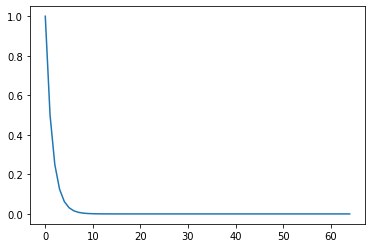

In [ ]:
plt.plot(x,y)

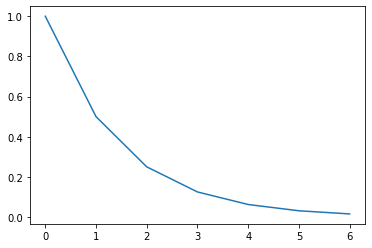

In [ ]:
plt.plot(x[:7],y[:7])

In [ ]:
function(y)

True

In [ ]:
#แปลงข้อมูลให้ Stationary (i(D))
def found_D(data, s):
  if s != 0:
    data_s = []
    for i in range(len(data)):
      if s*(i+1)-1 <= len(data)-1:
        data_s.append(data.values.tolist()[s*(i+1)-1])
    p_value = sm.tsa.stattools.adfuller(data_s)[1]
    D = 0
    while (p_value >= 0.05):
      D+=1
      data = data.diff(s).dropna()
      data_s = []
      for i in range(len(data)):
        if s*(i+1)-1 <= len(data)-1:
          data_s.append(data.values.tolist()[s*(i+1)-1])
      p_value = sm.tsa.stattools.adfuller(data_s)[1]
    return  D
  else: return 0

In [ ]:
#แปลงข้อมูลให้ Stationary (i(d))
def found_d(data):
  p_value = sm.tsa.stattools.adfuller(data)[1]
  d = 1
  while (p_value >= 0.05):
    d+=1
    data = data.diff(1).dropna()
    p_value = sm.tsa.stattools.adfuller(data)[1]
  return d

In [ ]:
#หา Autoregressive process of order p:
def found_p(data,s):
  p = []
  if s == 0: s = len(data)/4 -1
  acf = sm.graphics.tsa.acf(data, nlags= math.floor(len(data)/4))
  if function(acf):
    pacf = sm.graphics.tsa.pacf(data, nlags= math.floor(len(data)/4))
    for i in range(len(pacf)):
      if i != 0 and i < 5:
        if pacf[i] > 2/math.sqrt(len(pacf)):
          if i <= s: p.append(i)
        if pacf[i] < -2/math.sqrt(len(pacf)):
          if i  <= s: p.append(i)
  if p == []: p = [0]
  return p

In [ ]:
#หา Autoregressive process of order P 
def found_P(data, s):
  P = []; S_acf = []
  if s != 0:
    acf = sm.graphics.tsa.acf(data, nlags= math.floor(len(data)/4))
    for i in [1,2,3]:
      if s*(i+1) <= len(acf) and i != 0:
        S_acf.append([s*i])
    if function(S_acf):
      pacf = sm.graphics.tsa.pacf(data, nlags= math.floor(len(data)/4))
      for i in range(len(pacf)):
        if s*(i+1) <= len(pacf) and i != 0 and i < 5:
          if pacf[s*i] > 2/math.sqrt(len(pacf)):
            P.append(i)
          if pacf[s*i] < -2/math.sqrt(len(pacf)):
            P.append(i)
  if P == []: P = [0]
  return P

In [ ]:
#หา Moving Average Process of order q
def found_q(data, s):
  q = []
  if s == 0: s = len(data)/4
  pacf = sm.graphics.tsa.pacf(data, nlags= math.floor(len(data)/4))
  if function(pacf):
    acf = sm.graphics.tsa.acf(data, nlags= math.floor(len(data)/4))
    for i in range(len(pacf)):
      if i != 0 and i < 5:
        if pacf[i] > 2/math.sqrt(len(pacf)):
          if i <= s: q.append(i)
        if pacf[i] < -2/math.sqrt(len(data)):
          if i  <= s: q.append(i)
  if q == []: q = [0]
  return q

In [ ]:
#หา Moving Average Process of order Q
def found_Q(data,s):
  Q = []; S_pacf = []
  if s != 0:
    pacf = sm.graphics.tsa.pacf(data, nlags= math.floor(len(data)/4))
    for i in range(len(pacf)):
      if s*(i+1) <= len(pacf) and i != 0:
        S_pacf.append([s*i])
    if function(S_pacf):
      acf = sm.graphics.tsa.acf(data)
      for i in range(len(acf)):
        if s*(i+1) <= len(acf) and i != 0 and i < 5:
          if acf[s*i] > 2/math.sqrt(len(data)):
            Q.append(i)
          if acf[s*i] < -2/math.sqrt(len(data)):
            Q.append(i)
  if Q == []: Q = [0]
  return Q

In [ ]:
# set order arimax
def order_arimax(data, s, d):
  orders = []
  p = found_p(data, s)
  q = found_q(data, s)
  for i in p:
    for j in q:
      orders.append([i,d,j])
  return orders

In [ ]:
# set order sarimax
def order_sarimax(data, s, D):
  orders = []
  P = found_P(data, s)
  Q = found_Q(data, s)
  for i in P:
    for j in Q:
      orders.append([i,D,j,s])
  return orders

In [ ]:
#set Order
def order(y, freq):
  o = []
  s = Length_Seasonal(y,freq)
  y = np.log(y).dropna()
  d = found_d(y)
  if d != 0: 
    for i in range(d):
      y =y.diff(1).dropna()
  D = found_D(y, s)
  if D != 0: 
    for i in range(D):
      y = y.diff(s).dropna() 
  oa = order_arimax(y, s, d)
  os = order_sarimax(y, s, D)
  for I in oa:
    for J in os:
      o.append([I,J])
  return o

###Adjust

In [ ]:
#หา B
def B(r,p):
  b_sum = 0
  for i in range(len(r)-1):
    if r[i] < p[i+1]: 
      if r[i+1] >= r[i]: b_sum += p[i+1]-r[i]
  return b_sum/(len(r)-1)

In [ ]:
#หา A
def A(r,p):
  a_sum = 0
  for i in range(len(r)-1):
    if r[i] > p[i+1]: 
      if r[i+1] <= r[i]: a_sum += p[i+1]-r[i]
  return a_sum/(len(r)-1)

###Precision

In [ ]:
#Precision
def precision(y,x,order_arimax,order_sarimax):
  model = statsmodels.tsa.statespace.sarimax.SARIMAX(endog=y,order=order_arimax,seasonal_order=order_sarimax,initialization='approximate_diffuse').fit()
  n = len(y); r = y[:n-1].values; p = model.predict(1,n-1).values
  T = 0; N = 0
  a = A(r,p); b = B(r,p)
  for i in range(len(r)-1):
    if p[i+1] > r[i]: 
      if p[i+1] + a > r[i]:
        if r[i+1] > r[i] : T+=1; N+=1
        else: N+=1
    if p[i+1] < r[i]: 
      if p[i+1] + b > r[i]:
        if r[i+1] > r[i] : T+=1; N+=1
        else: N+=1
  return [T/N,a,b]

##Main Function

In [ ]:
#Indicator
def Indicator_Algorithm(FOREX_High, FOREX_Low, FOREX_Close, A, B, C):
  Y1 = FOREX_High; Y2 = FOREX_Low; Y3 = FOREX_Close
  Indicator = 'None'
  if len(Y1) == len(Y2) == len(Y3):  
    if EMA(Y3,A) == PSAR(Y1,Y2) == RSI(Y3,B) == WPR(Y1,Y2,Y3,C): Indicator = EMA(Y3,A)
    else: Indicator = 'Sideway'
    return Indicator
  else: return 'The data size must be the same.'

In [ ]:
#SARIMAX
def SARIMAX_Algorithm(FOREX_High, FOREX_Low,FOREX_Close, 
                      XAUUSD_Close, WTIUSD_Close, STOCK1_Close, STOCK2_Close,freq = 20):
  if len(FOREX_Close) >= 32:  
    Y1 = FOREX_High.reset_index(drop=True).drop(0).reset_index(drop=True)
    Y2 = FOREX_Low.reset_index(drop=True).drop(0).reset_index(drop=True)
    Y3 = FOREX_Close.reset_index(drop=True).drop(0).reset_index(drop=True)
    X1 = XAUUSD_Close.reset_index(drop=True).drop(len(XAUUSD_Close)-1).reset_index(drop=True)
    X2 = WTIUSD_Close.reset_index(drop=True).drop(len(XAUUSD_Close)-1).reset_index(drop=True)
    X3 = STOCK1_Close.reset_index(drop=True).drop(len(STOCK1_Close)-1).reset_index(drop=True)
    X4 = STOCK2_Close.reset_index(drop=True).drop(len(STOCK2_Close)-1).reset_index(drop=True)
    x =   inde_variable = pd.DataFrame({'X1':X1,'X2':X2,'X3':X3,'X4':X4})
    SARIMAX = 'None'
    if len(Y1) == len(Y2) == len(Y3) == len(X1) == len(X2) == len(X3) == len(X4):  
      for i in order(Y3, freq):
        Max = {}
        prec = precision(Y3, x, i[0],i[1])
        Max[prec[0]] = [i[0], i[1], prec[1], prec[2]]
      if max(Max.keys()) == 0:
        return 'Sideway'
      else:
        para = Max[max(Max.keys())]
        MODEL = statsmodels.tsa.statespace.sarimax.SARIMAX(endog=Y3,exog=x,order=para[0],seasonal_order=para[1],initialization='approximate_diffuse')
        forecast = MODEL.fit().forecast(1, exog =x[-1:].values.tolist()).values[0]
        real = Y3[-1:].values[0]
        if forecast > real:
          if forecast + para[2] > real: SARIMAX = 'Up'
          else: SARIMAX = 'Sideway'
        if forecast < real:
          if forecast + para[3] < real: SARIMAX = 'Down'
          else: SARIMAX = 'Sideway'
      return SARIMAX
    else: return 'The data size must be the same.'
  else: return 'Not enough data.'

In [ ]:
#All 
def All_Algorithm(FOREX_High, FOREX_Low,FOREX_Close, 
                  XAUUSD_Close, WTIUSD_Close, STOCK1_Close, STOCK2_Close,
                  A, B, C, freq = 20):
  if len(FOREX_Close) >= 32:  
    Y1 = FOREX_High.reset_index(drop=True).drop(0).reset_index(drop=True)
    Y2 = FOREX_Low.reset_index(drop=True).drop(0).reset_index(drop=True)
    Y3 = FOREX_Close.reset_index(drop=True).drop(0).reset_index(drop=True)
    X1 = XAUUSD_Close.reset_index(drop=True).drop(len(XAUUSD_Close)-1).reset_index(drop=True)
    X2 = WTIUSD_Close.reset_index(drop=True).drop(len(XAUUSD_Close)-1).reset_index(drop=True)
    X3 = STOCK1_Close.reset_index(drop=True).drop(len(STOCK1_Close)-1).reset_index(drop=True)
    X4 = STOCK2_Close.reset_index(drop=True).drop(len(STOCK2_Close)-1).reset_index(drop=True)
    x =   inde_variable = pd.DataFrame({'X1':X1,'X2':X2,'X3':X3,'X4':X4})
    Indicator = 'None'
    SARIMAX = 'None'
    if len(Y1) == len(Y2) == len(Y3) == len(X1) == len(X2) == len(X3) == len(X4):  
      if EMA(Y3,A) == PSAR(Y1,Y2) == RSI(Y3,B) == WPR(Y1,Y2,Y3,C): Indicator = EMA(Y3,A)
      else: Indicator = 'Sideway'
      if Indicator != 'Sideway':
        for i in order(Y3, freq):
          Max = {}
          prec = precision(Y3, x, i[0],i[1])
          Max[prec[0]] = [i[0], i[1], prec[1], prec[2]]
        if max(Max.keys()) == 0:
          return 'Sideway'
        else:
          para = Max[max(Max.keys())]
          MODEL = statsmodels.tsa.statespace.sarimax.SARIMAX(endog=Y3,exog=x,order=para[0],seasonal_order=para[1],initialization='approximate_diffuse')
          forecast = MODEL.fit().forecast(1, exog =x[-1:].values.tolist()).values[0]
          real = Y3[-1:].values[0]
          if forecast > real:
            if forecast + para[2] > real: SARIMAX = 'Up'
            else: SARIMAX = 'Sideway'
          if forecast < real:
            if forecast + para[3] < real: SARIMAX = 'Down'
            else: SARIMAX = 'Sideway'
          if SARIMAX != 'Sideway':
            if SARIMAX == Indicator: return Indicator
            else: return 'Sideway'
          else: return 'Sideway'
      else: return 'Sideway'
    else: return 'The data size must be the same.'
  else: return 'Not enough data.'

#Testing

##Indicator

In [ ]:
#การทดสอบ
Trend = []; Close = []; Date = []
for i in range(1827):
  if i >= 1306 and i + 260 <= 1826:
    start = i; stop =  i + 260
    Date.append(EURUSD['Date'][stop])
    Close.append(EURUSD['Close'][stop])
    Trend.append(Indicator_Algorithm(EURUSD['High'][start:stop], EURUSD['Low'][start:stop], EURUSD['Close'][start:stop], 5, 20, 20))
Indicator_Testing = pd.DataFrame({'Date':Date, 'Close':Close, 'Trend':Trend})
Indicator_Testing.head()

,Date,Close,Trend
0,2021-01-01,1.22241,Sideway
1,2021-01-04,1.22490,Sideway
2,2021-01-05,1.22921,Up
3,2021-01-06,1.23215,Up
4,2021-01-07,1.22676,Up


In [ ]:
#แนวโน้มจริง
Real = ['Sideway']
for i in range(len(Indicator_Testing)):
  if i > 0:
    if Indicator_Testing['Close'][i] > Indicator_Testing['Close'][i-1]:
      Real.append('Up')
    elif Indicator_Testing['Close'][i] < Indicator_Testing['Close'][i-1]:
      Real.append('Down')
    else: Real.append('Sideway')
Indicator_Testing['Real'] = Real
Indicator_Testing.head()

,Date,Close,Trend,Real
0,2021-01-01,1.22241,Sideway,Sideway
1,2021-01-04,1.22490,Sideway,Up
2,2021-01-05,1.22921,Up,Up
3,2021-01-06,1.23215,Up,Up
4,2021-01-07,1.22676,Up,Down


In [ ]:
#ตัด Sideway
Indicator_Testing_today = Indicator_Testing[Indicator_Testing['Trend'] != 'Sideway'].reset_index()[['Date', 'Trend', 'Real']]
Indicator_Testing_today.head()

,Date,Trend,Real
0,2021-01-05,Up,Up
1,2021-01-06,Up,Up
2,2021-01-07,Up,Down
3,2021-01-18,Down,Up
4,2021-01-19,Down,Up


In [ ]:
#มีสัญญาณการซื้อขายทั้งหมด
Indicator_Testing_today['Trend'].count()

141

In [ ]:
#พยากรณ์ถูกต้องทั้งหมด
T = 0
for i in Indicator_Testing_today.iterrows():
  if i[1]['Trend'] == i[1]['Real']: T+=1
T/Indicator_Testing_today['Trend'].count()*100

51.77304964539007

In [ ]:
T

73

In [ ]:
#เป็นสัญญาณ Up
Up = 0
for i in Indicator_Testing_today.iterrows():
  if i[1]['Trend'] == 'Up': Up+=1
print('Up = ', Up)

Up =  42


In [ ]:
#เป็นสัญญาณ Down
Down = 0
for i in Indicator_Testing_today.iterrows():
  if i[1]['Trend'] == 'Down': Down+=1
print('Down = ', Down)

Down =  99


In [ ]:
#เป็นสัญญาณ Up ที่ถูกต้อง
T = 0
for i in Indicator_Testing_today.iterrows():
  if i[1]['Trend'] == 'Up': 
    if i[1]['Trend'] == i[1]['Real']: T+=1
print('Up Win = ', T, ', % = ', T/Up*100)

Up Win =  21 , % =  50.0


In [ ]:
#เป็นสัญญาณ Down ที่ถูกต้อง
T = 0
for i in Indicator_Testing_today.iterrows():
  if i[1]['Trend'] == 'Down': 
    if i[1]['Trend'] == i[1]['Real']: T+=1
print('Down Win = ', T, ', % = ', T/Down*100)

Down Win =  52 , % =  52.52525252525253


In [ ]:
#แนวโน้มที่เกิดขึ้นทั้งหมด
Trend = []; OpenDate = []; CloseDate = []
OpenPosition = [1.2241]; ClosePosition = [];
for i in range(len(Indicator_Testing)):
  if len(Trend) == 0:
    OpenDate.append(Indicator_Testing['Date'][i])
    Trend.append(Indicator_Testing['Trend'][i])
  if len(Trend) != 0 and Trend[-1] != Indicator_Testing['Trend'][i]:
    ClosePosition.append(Indicator_Testing['Close'][i-1])
    CloseDate.append(Indicator_Testing['Date'][i])
    Trend.append(Indicator_Testing['Trend'][i])
    OpenPosition.append(Indicator_Testing['Close'][i-1])
    OpenDate.append(Indicator_Testing['Date'][i])
  if i == len(Indicator_Testing)-1  and len(OpenPosition) != len(ClosePosition) and len(OpenDate) != len(CloseDate): 
    ClosePosition.append(Indicator_Testing['Close'][-1:].values[0])
    CloseDate.append(Indicator_Testing['Date'][-1:].values[0])
Indicator_Testing_Trend = pd.DataFrame({'Trend':Trend, 'Open Date': OpenDate, 
                           'Close Date': CloseDate, 'Open Position':OpenPosition, 
                           'Close Position':ClosePosition})                    
Indicator_Testing_Trend.head()

,Trend,Open Date,Close Date,Open Position,Close Position
0,Sideway,2021-01-01,2021-01-05,1.22410,1.22490
1,Up,2021-01-05,2021-01-08,1.22490,1.22676
2,Sideway,2021-01-08,2021-01-18,1.22676,1.20743
3,Down,2021-01-18,2021-01-20,1.20743,1.21255
4,Sideway,2021-01-20,2021-01-21,1.21255,1.21044


In [ ]:
#แนวโน้มจริง
Real = []
for i in range(len(Indicator_Testing_Trend)):
  if Indicator_Testing_Trend['Open Position'][i] < Indicator_Testing_Trend['Close Position'][i]:
    Real.append('Up')
  elif Indicator_Testing_Trend['Open Position'][i] > Indicator_Testing_Trend['Close Position'][i]:
    Real.append('Down')
  else: Real.append('Sideway')
Indicator_Testing_Trend['Real'] = Real
Indicator_Testing_Trend.head()

,Trend,Open Date,Close Date,Open Position,Close Position,Real
0,Sideway,2021-01-01,2021-01-05,1.22410,1.22490,Up
1,Up,2021-01-05,2021-01-08,1.22490,1.22676,Up
2,Sideway,2021-01-08,2021-01-18,1.22676,1.20743,Down
3,Down,2021-01-18,2021-01-20,1.20743,1.21255,Up
4,Sideway,2021-01-20,2021-01-21,1.21255,1.21044,Down


In [ ]:
#ตัด Sideway
Indicator_Testing_Trend = Indicator_Testing_Trend[Indicator_Testing_Trend['Trend'] != 'Sideway'].reset_index()[['Trend', 'Open Date', 'Close Date', 'Open Position', 'Close Position', 'Real']]
Indicator_Testing_Trend.head()

,Trend,Open Date,Close Date,Open Position,Close Position,Real
0,Up,2021-01-05,2021-01-08,1.22490,1.22676,Up
1,Down,2021-01-18,2021-01-20,1.20743,1.21255,Up
2,Down,2021-01-21,2021-01-22,1.21044,1.21611,Up
3,Down,2021-02-02,2021-02-08,1.20569,1.20472,Down
4,Up,2021-02-10,2021-02-17,1.21185,1.21027,Down


In [ ]:
#มีสัญญาณการซื้อขายทั้งหมด
Indicator_Testing_Trend['Trend'].count()

31

In [ ]:
#พยากรณ์ถูกต้องทั้งหมด
T = 0
for i in Indicator_Testing_Trend.iterrows():
  if i[1]['Trend'] == i[1]['Real']: T+=1
print('Win = ', T, ', % = ', T/Indicator_Testing_Trend['Trend'].count()*100)

Win =  12 , % =  38.70967741935484


In [ ]:
#เป็นสัญญาณ Up
Up = 0
for i in Indicator_Testing_Trend.iterrows():
  if i[1]['Trend'] == 'Up': Up+=1
print('Up = ', Up)

Up =  9


In [ ]:
#เป็นสัญญาณ Down
Down = 0
for i in Indicator_Testing_Trend.iterrows():
  if i[1]['Trend'] == 'Down': Down+=1
print('Down = ', Down)

Down =  22


In [ ]:
#เป็นสัญญาณ Up ที่ถูกต้อง
T = 0
for i in Indicator_Testing_Trend.iterrows():
  if i[1]['Trend'] == 'Up': 
    if i[1]['Trend'] == i[1]['Real']: T+=1
print('Up Win = ', T, ', % = ', T/Up*100)

Up Win =  4 , % =  44.44444444444444


In [ ]:
#เป็นสัญญาณ Down ที่ถูกต้อง
T = 0
for i in Indicator_Testing_Trend.iterrows():
  if i[1]['Trend'] == 'Down': 
    if i[1]['Trend'] == i[1]['Real']: T+=1
print('Down Win = ', T, ', % = ', T/Down*100)

Down Win =  8 , % =  36.36363636363637


In [ ]:
#ระยะเวลาการถือครองตามแนวโน้มโดยเฉลี่ย
Day  = 0
for i in Indicator_Testing_Trend.iterrows():
  Day =+ (i[1]['Close Date'] - i[1]['Open Date'])
print('ระยะเวลาการถือครองตามแนวโน้มโดยเฉลี่ย เท่ากับ ', Day/Indicator_Testing_Trend['Trend'].count(), ' วัน')

ระยะเวลาการถือครองตามแนวโน้มโดยเฉลี่ย เท่ากับ  0 days 02:19:21.290322580  วัน


##SARIMAX

In [ ]:
#การ set Order 
for i in range(1827):
  if i >= 1304 and i + 260 <= 1826:
    start = i; stop =  i + 260
    print(i,order(EURUSD['Close'][start:stop], 20))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


1304 [[[1, 2, 1], [0, 1, 0, 20]], [[1, 2, 2], [0, 1, 0, 20]], [[1, 2, 4], [0, 1, 0, 20]], [[4, 2, 1], [0, 1, 0, 20]], [[4, 2, 2], [0, 1, 0, 20]], [[4, 2, 4], [0, 1, 0, 20]]]
1305 [[[1, 2, 1], [0, 2, 0, 20]], [[1, 2, 2], [0, 2, 0, 20]], [[1, 2, 4], [0, 2, 0, 20]]]
1306 [[[1, 2, 1], [0, 0, 0, 20]], [[1, 2, 2], [0, 0, 0, 20]], [[1, 2, 3], [0, 0, 0, 20]], [[1, 2, 4], [0, 0, 0, 20]]]
1307 [[[1, 2, 1], [0, 0, 0, 20]], [[1, 2, 2], [0, 0, 0, 20]], [[1, 2, 3], [0, 0, 0, 20]], [[1, 2, 4], [0, 0, 0, 20]]]
1308 [[[1, 2, 1], [0, 1, 0, 20]], [[1, 2, 2], [0, 1, 0, 20]], [[1, 2, 4], [0, 1, 0, 20]], [[4, 2, 1], [0, 1, 0, 20]], [[4, 2, 2], [0, 1, 0, 20]], [[4, 2, 4], [0, 1, 0, 20]]]
1309 [[[1, 2, 1], [0, 0, 0, 20]], [[1, 2, 2], [0, 0, 0, 20]], [[1, 2, 3], [0, 0, 0, 20]], [[1, 2, 4], [0, 0, 0, 20]], [[4, 2, 1], [0, 0, 0, 20]], [[4, 2, 2], [0, 0, 0, 20]], [[4, 2, 3], [0, 0, 0, 20]], [[4, 2, 4], [0, 0, 0, 20]]]
1310 [[[1, 2, 1], [0, 1, 0, 20]], [[1, 2, 2], [0, 1, 0, 20]], [[1, 2, 4], [0, 1, 0, 20]], [[4, 2

/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


1523 [[[2, 2, 1], [0, 5, 0, 20]], [[2, 2, 2], [0, 5, 0, 20]], [[2, 2, 3], [0, 5, 0, 20]], [[2, 2, 4], [0, 5, 0, 20]]]
1524 [[[1, 2, 1], [0, 0, 0, 20]], [[1, 2, 2], [0, 0, 0, 20]], [[1, 2, 3], [0, 0, 0, 20]], [[1, 2, 4], [0, 0, 0, 20]], [[2, 2, 1], [0, 0, 0, 20]], [[2, 2, 2], [0, 0, 0, 20]], [[2, 2, 3], [0, 0, 0, 20]], [[2, 2, 4], [0, 0, 0, 20]]]
1525 [[[1, 2, 1], [0, 2, 0, 20]], [[1, 2, 2], [0, 2, 0, 20]], [[1, 2, 3], [0, 2, 0, 20]], [[1, 2, 4], [0, 2, 0, 20]], [[2, 2, 1], [0, 2, 0, 20]], [[2, 2, 2], [0, 2, 0, 20]], [[2, 2, 3], [0, 2, 0, 20]], [[2, 2, 4], [0, 2, 0, 20]], [[4, 2, 1], [0, 2, 0, 20]], [[4, 2, 2], [0, 2, 0, 20]], [[4, 2, 3], [0, 2, 0, 20]], [[4, 2, 4], [0, 2, 0, 20]]]
1526 [[[1, 2, 1], [0, 0, 0, 20]], [[1, 2, 2], [0, 0, 0, 20]], [[1, 2, 3], [0, 0, 0, 20]], [[1, 2, 4], [0, 0, 0, 20]], [[2, 2, 1], [0, 0, 0, 20]], [[2, 2, 2], [0, 0, 0, 20]], [[2, 2, 3], [0, 0, 0, 20]], [[2, 2, 4], [0, 0, 0, 20]], [[3, 2, 1], [0, 0, 0, 20]], [[3, 2, 2], [0, 0, 0, 20]], [[3, 2, 3], [0, 0, 0, 20

###1

In [ ]:
#index เริ่มต้นมกราคมย้อนหลัง
EURUSD[EURUSD['Date'] == datetime(2020,1,1)]

,Date,Open,High,Low,Close
1304,2020-01-01,1.11967,1.12384,1.11963,1.12282


In [ ]:
#index สิ้นสุดข้อมูลย้อนหลัง
EURUSD[EURUSD['Date'] == datetime(2020,12,31)]

,Date,Open,High,Low,Close
1565,2020-12-31,1.22922,1.23083,1.22201,1.22241


In [ ]:
#step สิ้นสุดข้อมูลย้อนหลัง - เริ่มต้นมกราคมย้อนหลัง
EURUSD[EURUSD['Date'] == datetime(2020,12,31)].index[0] - EURUSD[EURUSD['Date'] == datetime(2020,1,1)].index[0] + 1

262

In [ ]:
#index สิ้นสุดมกราคมทดสอบ
EURUSD[EURUSD['Date'] == datetime(2021,1,29)]

,Date,Open,High,Low,Close
1586,2021-01-29,1.21177,1.21551,1.20937,1.2136


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


************************************************* 2021-01-01 00:00:00  =  Down


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


************************************************* 2021-01-04 00:00:00  =  Sideway


KeyboardInterrupt: ignored

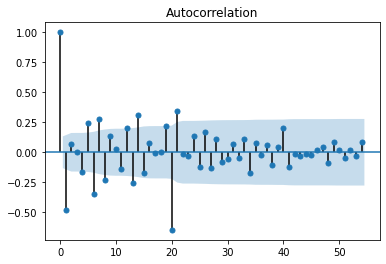

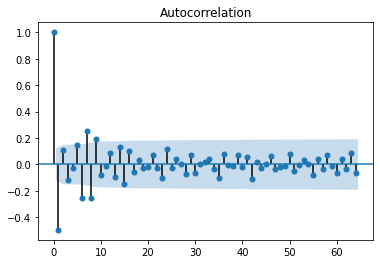

In [ ]:
#การทดสอบ
step = 262
end = 1586+1
for i in range(1827):
  if i >= 1304 and i + step <= end:
    start = i; stop =  i + step
    forcast = SARIMAX_Algorithm(EURUSD['High'][start:stop], EURUSD['Low'][start:stop], EURUSD['Close'][start:stop], 
                        XAUUSD['Close'][start:stop], WTIUSD['Close'][start:stop], STOXX['Close'][start:stop], 
                        SPX['Close'][start:stop])
    print('*************************************************',EURUSD['Date'][stop],' = ',forcast)

###2

In [ ]:
#index เริ่มต้นกุมภาพันธ์ย้อนหลัง
EURUSD[EURUSD['Date'] == datetime(2020,2,3)]

,Date,Open,High,Low,Close
1327,2020-02-03,1.1092,1.10924,1.10349,1.10586


In [ ]:
#index สิ้นสุดข้อมูลย้อนหลัง
EURUSD[EURUSD['Date'] == datetime(2021,1,29)]

,Date,Open,High,Low,Close
1586,2021-01-29,1.21177,1.21551,1.20937,1.2136


In [ ]:
#step สิ้นสุดข้อมูลย้อนหลัง - เริ่มต้นกุมภาพันธ์ย้อนหลัง
EURUSD[EURUSD['Date'] == datetime(2021,1,29)].index[0] - EURUSD[EURUSD['Date'] == datetime(2020,2,3)].index[0] + 1

260

In [ ]:
#index สิ้นสุดกุมภาพันธ์ทดสอบ
EURUSD[EURUSD['Date'] == datetime(2021,2,26)]

,Date,Open,High,Low,Close
1606,2021-02-26,1.21742,1.21829,1.20613,1.20719


In [ ]:
#การทดสอบ
step = 260
end = 1606+1
for i in range(1827):
  if i >= 1327 and i + step <= end:
    start = i; stop =  i + step
    forcast = All_Algorithm(EURUSD['High'][start:stop], EURUSD['Low'][start:stop], EURUSD['Close'][start:stop], 
                        XAUUSD['Close'][start:stop], WTIUSD['Close'][start:stop], STOXX['Close'][start:stop], 
                        SPX['Close'][start:stop],5,20,20)
    print('*************************************************',EURUSD['Date'][stop],' = ',forcast)

###3

In [ ]:
#index เริ่มต้นมีนาคมย้อนหลัง
EURUSD[EURUSD['Date'] == datetime(2020,3,2)]

In [ ]:
#index สิ้นสุดข้อมูลย้อนหลัง
EURUSD[EURUSD['Date'] == datetime(2021,2,26)]

In [ ]:
#step สิ้นสุดข้อมูลย้อนหลัง - เริ่มต้นมีนาคมย้อนหลัง
EURUSD[EURUSD['Date'] == datetime(2021,2,26)].index[0] - EURUSD[EURUSD['Date'] == datetime(2020,3,2)].index[0] + 1

In [ ]:
#index สิ้นมีนาคมทดสอบ
EURUSD[EURUSD['Date'] == datetime(2021,3,31)]

In [ ]:
#การทดสอบ
step = 260
end = 1629
for i in range(1827): 
  if i >= 1347 and i + step <= end:
    start = i; stop =  i + step
    forcast = SARIMAX_Algorithm(EURUSD['High'][start:stop], EURUSD['Low'][start:stop], EURUSD['Close'][start:stop], 
                        XAUUSD['Close'][start:stop], WTIUSD['Close'][start:stop], STOXX['Close'][start:stop], 
                        SPX['Close'][start:stop])
    print('*************************************************',EURUSD['Date'][stop],' = ',forcast)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood op

************************************************* 2021-03-01 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-03-02 00:00:00  =  Down


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


************************************************* 2021-03-03 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-03-04 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-03-05 00:00:00  =  Up


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-03-08 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-03-09 00:00:00  =  Down


/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.

************************************************* 2021-03-10 00:00:00  =  Down


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-03-11 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-03-12 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-03-15 00:00:00  =  Up


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-03-16 00:00:00  =  Down


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-03-17 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-03-18 00:00:00  =  Up


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-03-19 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-03-22 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-03-23 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-03-24 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-03-25 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-03-26 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-03-29 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


************************************************* 2021-03-30 00:00:00  =  Up


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


************************************************* 2021-03-31 00:00:00  =  Down


###4

In [ ]:
#index เริ่มต้นเมษายนย้อนหลัง
EURUSD[EURUSD['Date'] == datetime(2020,4,1)]

In [ ]:
#index สิ้นสุดข้อมูลย้อนหลัง
EURUSD[EURUSD['Date'] == datetime(2021,3,31)]

In [ ]:
#step สิ้นสุดข้อมูลย้อนหลัง - เริ่มต้นเมษายนย้อนหลัง
EURUSD[EURUSD['Date'] == datetime(2021,3,31)].index[0] - EURUSD[EURUSD['Date'] == datetime(2020,4,1)].index[0] + 1

In [ ]:
#index สิ้นสุดเมษายนทดสอบ
EURUSD[EURUSD['Date'] == datetime(2021,4,30)]

In [ ]:
#การทดสอบ
step = 261
end = 1651
for i in range(1827):
  if i >= 1369 and i + step <= end:
    start = i; stop =  i + step
    forcast = SARIMAX_Algorithm(EURUSD['High'][start:stop], EURUSD['Low'][start:stop], EURUSD['Close'][start:stop], 
                        XAUUSD['Close'][start:stop], WTIUSD['Close'][start:stop], STOXX['Close'][start:stop], 
                        SPX['Close'][start:stop])
    print('*************************************************',EURUSD['Date'][stop],' = ',forcast)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals",

************************************************* 2021-04-01 00:00:00  =  Down


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


************************************************* 2021-04-02 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimiza

************************************************* 2021-04-05 00:00:00  =  Sideway
************************************************* 2021-04-06 00:00:00  =  Up


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-04-07 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


************************************************* 2021-04-08 00:00:00  =  Up


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-04-09 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


************************************************* 2021-04-12 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-04-13 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-04-14 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-04-15 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-04-16 00:00:00  =  Down


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-04-19 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-04-20 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-04-21 00:00:00  =  Down


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


************************************************* 2021-04-22 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-04-23 00:00:00  =  Down


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-04-26 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-04-27 00:00:00  =  Up


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-04-28 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-04-29 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-04-30 00:00:00  =  Sideway


###5

In [ ]:
#index เริ่มต้นพฤษภาคมย้อนหลัง
EURUSD[EURUSD['Date'] == datetime(2020,5,1)]

In [ ]:
#index สิ้นสุดข้อมูลย้อนหลัง
EURUSD[EURUSD['Date'] == datetime(2021,4,30)]

In [ ]:
#step สิ้นสุดข้อมูลย้อนหลัง - เริ่มต้นพฤษภาคมย้อนหลัง
EURUSD[EURUSD['Date'] == datetime(2021,4,30)].index[0] - EURUSD[EURUSD['Date'] == datetime(2020,5,1)].index[0] + 1

In [ ]:
#index สิ้นสุดพฤษภาคมทดสอบ
EURUSD[EURUSD['Date'] == datetime(2021,5,31)]

In [ ]:
#การทดสอบ
step = 261
end = 1672+1
for i in range(1827):
  if i >= 1391 and i + step <= end:
    start = i; stop =  i + step
    forcast = SARIMAX_Algorithm(EURUSD['High'][start:stop], EURUSD['Low'][start:stop], EURUSD['Close'][start:stop], 
                        XAUUSD['Close'][start:stop], WTIUSD['Close'][start:stop], STOXX['Close'][start:stop], 
                        SPX['Close'][start:stop])
    print('*************************************************',EURUSD['Date'][stop],' = ',forcast)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood op

************************************************* 2021-05-03 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-05-04 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-05-05 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


************************************************* 2021-05-06 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-05-07 00:00:00  =  Up


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-05-10 00:00:00  =  Down


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


************************************************* 2021-05-11 00:00:00  =  Sideway
************************************************* 2021-05-12 00:00:00  =  Up


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


************************************************* 2021-05-13 00:00:00  =  None
************************************************* 2021-05-14 00:00:00  =  None


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-05-17 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-05-18 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-05-19 00:00:00  =  Up


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


************************************************* 2021-05-20 00:00:00  =  Sideway
************************************************* 2021-05-21 00:00:00  =  Up
************************************************* 2021-05-24 00:00:00  =  None


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-05-25 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-05-26 00:00:00  =  Up


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-05-27 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


************************************************* 2021-05-28 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-05-31 00:00:00  =  Down


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-06-01 00:00:00  =  Down


###6

In [ ]:
#index เริ่มต้นมิถุนายนย้อนหลัง
EURUSD[EURUSD['Date'] == datetime(2020,6,1)]

In [ ]:
#index สิ้นสุดข้อมูลย้อนหลัง
EURUSD[EURUSD['Date'] == datetime(2021,5,31)]

In [ ]:
#step สิ้นสุดข้อมูลย้อนหลัง - เริ่มต้นมิถุนายนย้อนหลัง
EURUSD[EURUSD['Date'] == datetime(2021,5,31)].index[0] - EURUSD[EURUSD['Date'] == datetime(2020,6,1)].index[0] + 1

In [ ]:
#index สิ้นสุดมิถุนายนทดสอบ
EURUSD[EURUSD['Date'] == datetime(2021,6,30)]

In [ ]:
#การทดสอบ
step = 261
end = 1694
for i in range(1827):
  if i >= 1412 and i + step <= end:
    start = i; stop =  i + step
    forcast = SARIMAX_Algorithm(EURUSD['High'][start:stop], EURUSD['Low'][start:stop], EURUSD['Close'][start:stop], 
                        XAUUSD['Close'][start:stop], WTIUSD['Close'][start:stop], STOXX['Close'][start:stop], 
                        SPX['Close'][start:stop])
    print('*************************************************',EURUSD['Date'][stop],' = ',forcast)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/py

************************************************* 2021-06-01 00:00:00  =  Down


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


************************************************* 2021-06-02 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


************************************************* 2021-06-03 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-06-04 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-06-07 00:00:00  =  Down


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-06-08 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-06-09 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-06-10 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-06-11 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-06-14 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-06-15 00:00:00  =  Down


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


************************************************* 2021-06-16 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-06-17 00:00:00  =  Down
************************************************* 2021-06-18 00:00:00  =  None


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-06-21 00:00:00  =  Down


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


************************************************* 2021-06-22 00:00:00  =  Down


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-06-23 00:00:00  =  Up
************************************************* 2021-06-24 00:00:00  =  None
************************************************* 2021-06-25 00:00:00  =  None


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


************************************************* 2021-06-28 00:00:00  =  Sideway
************************************************* 2021-06-29 00:00:00  =  None
************************************************* 2021-06-30 00:00:00  =  Sideway


###7

In [ ]:
#index เริ่มต้นกรกฎาคมย้อนหลัง
EURUSD[EURUSD['Date'] == datetime(2020,7,1)]

,Date,Open,High,Low,Close
1434,2020-07-01,1.12285,1.12742,1.11842,1.12499


In [ ]:
#index สิ้นสุดข้อมูลย้อนหลัง
EURUSD[EURUSD['Date'] == datetime(2021,6,30)]

In [ ]:
#step สิ้นสุดข้อมูลย้อนหลัง - เริ่มต้นกรกฎาคมย้อนหลัง
EURUSD[EURUSD['Date'] == datetime(2021,6,30)].index[0] - EURUSD[EURUSD['Date'] == datetime(2020,7,1)].index[0] + 1

In [ ]:
#index สิ้นสุดกรกฎาคมทดสอบ
EURUSD[EURUSD['Date'] == datetime(2021,7,30)]

,Date,Open,High,Low,Close
1716,2021-07-30,1.18804,1.1908,1.18508,1.18665


In [ ]:
#การทดสอบ
step = 261
end = 1716
for i in range(1827):
  if i >= 1434 and i + step <= end:
    start = i; stop =  i + step
    forcast = SARIMAX_Algorithm(EURUSD['High'][start:stop], EURUSD['Low'][start:stop], EURUSD['Close'][start:stop], 
                        XAUUSD['Close'][start:stop], WTIUSD['Close'][start:stop], STOXX['Close'][start:stop], 
                        SPX['Close'][start:stop])
    print('*************************************************',EURUSD['Date'][stop],' = ',forcast)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals",

************************************************* 2021-07-01 00:00:00  =  Down
************************************************* 2021-07-02 00:00:00  =  None
************************************************* 2021-07-05 00:00:00  =  None


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


************************************************* 2021-07-06 00:00:00  =  Down
************************************************* 2021-07-07 00:00:00  =  None


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


************************************************* 2021-07-08 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


************************************************* 2021-07-09 00:00:00  =  Down
************************************************* 2021-07-12 00:00:00  =  None
************************************************* 2021-07-13 00:00:00  =  Sideway
************************************************* 2021-07-14 00:00:00  =  Down
************************************************* 2021-07-15 00:00:00  =  None
************************************************* 2021-07-16 00:00:00  =  None


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


************************************************* 2021-07-19 00:00:00  =  Up


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-07-20 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.

************************************************* 2021-07-21 00:00:00  =  Down


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-07-22 00:00:00  =  Up


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


************************************************* 2021-07-23 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-07-26 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-07-27 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-07-28 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-07-29 00:00:00  =  Up


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


************************************************* 2021-07-30 00:00:00  =  Up


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


###8

In [ ]:
#index เริ่มต้นสิงหาคมย้อนหลัง
EURUSD[EURUSD['Date'] == datetime(2020,8,3)]

In [ ]:
#index สิ้นสุดข้อมูลย้อนหลัง
EURUSD[EURUSD['Date'] == datetime(2021,7,30)]

In [ ]:
#step สิ้นสุดข้อมูลย้อนหลัง - เริ่มต้นสิงหาคมย้อนหลัง
EURUSD[EURUSD['Date'] == datetime(2021,7,30)].index[0] - EURUSD[EURUSD['Date'] == datetime(2020,8,3)].index[0] + 1

In [ ]:
#index สิ้นสุดสิงหาคมทดสอบ
EURUSD[EURUSD['Date'] == datetime(2021,8,31)]

In [ ]:
#การทดสอบ
step = 260
end = 1738
for i in range(1827):
  if i >= 1457 and i + step <= end:
    start = i; stop =  i + step
    forcast = SARIMAX_Algorithm(EURUSD['High'][start:stop], EURUSD['Low'][start:stop], EURUSD['Close'][start:stop], 
                        XAUUSD['Close'][start:stop], WTIUSD['Close'][start:stop], STOXX['Close'][start:stop], 
                        SPX['Close'][start:stop])
    print('*************************************************',EURUSD['Date'][stop],' = ',forcast)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood op

************************************************* 2021-08-02 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.

************************************************* 2021-08-03 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-08-04 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-08-05 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-08-06 00:00:00  =  Up


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-08-09 00:00:00  =  Down


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-08-10 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-08-11 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-08-12 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-08-13 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-08-16 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


************************************************* 2021-08-17 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-08-18 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-08-19 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-08-20 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-08-23 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-08-24 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-08-25 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-08-26 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-08-27 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-08-30 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-08-31 00:00:00  =  Sideway


###9

In [ ]:
#index เริ่มต้นกันยายนย้อนหลัง
EURUSD[EURUSD['Date'] == datetime(2020,9,1)]

In [ ]:
#index สิ้นสุดข้อมูลย้อนหลัง
EURUSD[EURUSD['Date'] == datetime(2021,8,31)]

In [ ]:
#step สิ้นสุดข้อมูลย้อนหลัง - เริ่มต้นกันยายนย้อนหลัง
EURUSD[EURUSD['Date'] == datetime(2021,8,31)].index[0] - EURUSD[EURUSD['Date'] == datetime(2020,9,1)].index[0] + 1

In [ ]:
#index สิ้นสุดกันยายนทดสอบ
EURUSD[EURUSD['Date'] == datetime(2021,9,30)]

In [ ]:
#การทดสอบ
step = 261
end = 1760
for i in range(1827):
  if i >= 1478 and i + step <= end:
    start = i; stop =  i + step
    forcast = SARIMAX_Algorithm(EURUSD['High'][start:stop], EURUSD['Low'][start:stop], EURUSD['Close'][start:stop], 
                        XAUUSD['Close'][start:stop], WTIUSD['Close'][start:stop], STOXX['Close'][start:stop], 
                        SPX['Close'][start:stop])
    print('*************************************************',EURUSD['Date'][stop],' = ',forcast)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.


************************************************* 2021-09-01 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-09-02 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-09-03 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-09-06 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-09-07 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-09-08 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-09-09 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-09-10 00:00:00  =  Up


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-09-13 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-09-14 00:00:00  =  Down


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


************************************************* 2021-09-15 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-09-16 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-09-17 00:00:00  =  Up


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-09-20 00:00:00  =  Up


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-09-21 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-09-22 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


************************************************* 2021-09-23 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-09-24 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-09-27 00:00:00  =  Down


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-09-28 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-09-29 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-09-30 00:00:00  =  Sideway


###10

In [ ]:
#index เริ่มต้นตุลาคมย้อนหลัง
EURUSD[EURUSD['Date'] == datetime(2020,10,1)]

In [ ]:
#index สิ้นสุดข้อมูลย้อนหลัง
EURUSD[EURUSD['Date'] == datetime(2021,9,30)]

In [ ]:
#step สิ้นสุดข้อมูลย้อนหลัง - เริ่มต้นตุลาคมย้อนหลัง
EURUSD[EURUSD['Date'] == datetime(2021,9,30)].index[0] - EURUSD[EURUSD['Date'] == datetime(2020,10,1)].index[0] + 1

In [ ]:
#index สิ้นสุดตุลาคมทดสอบ
EURUSD[EURUSD['Date'] == datetime(2021,10,29)]

In [ ]:
#การทดสอบ
step = 261
end = 1781
for i in range(1827):
  if i >= 1500 and i + step <= end:
    start = i; stop =  i + step
    forcast = SARIMAX_Algorithm(EURUSD['High'][start:stop], EURUSD['Low'][start:stop], EURUSD['Close'][start:stop], 
                        XAUUSD['Close'][start:stop], WTIUSD['Close'][start:stop], STOXX['Close'][start:stop], 
                        SPX['Close'][start:stop])
    print('*************************************************',EURUSD['Date'][stop],' = ',forcast)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parame

************************************************* 2021-10-01 00:00:00  =  Down


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-10-04 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


************************************************* 2021-10-05 00:00:00  =  Down


/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.

************************************************* 2021-10-06 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-10-07 00:00:00  =  Up


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-10-08 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


************************************************* 2021-10-11 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-10-12 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


************************************************* 2021-10-13 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


************************************************* 2021-10-14 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-10-15 00:00:00  =  Down


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


************************************************* 2021-10-18 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


************************************************* 2021-10-19 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-10-20 00:00:00  =  Up


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


************************************************* 2021-10-21 00:00:00  =  Up


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-10-22 00:00:00  =  Down


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


************************************************* 2021-10-25 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


************************************************* 2021-10-26 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


************************************************* 2021-10-27 00:00:00  =  Down


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


************************************************* 2021-10-28 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


************************************************* 2021-10-29 00:00:00  =  Up


###11

In [ ]:
#index เริ่มต้นพฤศจิกายนย้อนหลัง
EURUSD[EURUSD['Date'] == datetime(2020,11,2)]

In [ ]:
#index สิ้นสุดข้อมูลย้อนหลัง
EURUSD[EURUSD['Date'] == datetime(2021,10,29)]

In [ ]:
#step สิ้นสุดข้อมูลย้อนหลัง - เริ่มต้นพฤศจิกายนย้อนหลัง
EURUSD[EURUSD['Date'] == datetime(2021,10,29)].index[0] - EURUSD[EURUSD['Date'] == datetime(2020,11,2)].index[0] + 1

In [ ]:
#index สิ้นสุดพฤศจิกายนทดสอบ
EURUSD[EURUSD['Date'] == datetime(2021,11,30)]

In [ ]:
#การทดสอบ
step = 260
end = 1803
for i in range(1827):
  if i >= 1522 and i + step <= end:
    start = i; stop =  i + step
    forcast = SARIMAX_Algorithm(EURUSD['High'][start:stop], EURUSD['Low'][start:stop], EURUSD['Close'][start:stop], 
                        XAUUSD['Close'][start:stop], WTIUSD['Close'][start:stop], STOXX['Close'][start:stop], 
                        SPX['Close'][start:stop],)
    print('*************************************************',EURUSD['Date'][stop],' = ',forcast)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/py

************************************************* 2021-11-01 00:00:00  =  Down


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimiza

************************************************* 2021-11-02 00:00:00  =  Up


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-11-03 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-11-04 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-11-05 00:00:00  =  Up


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-11-08 00:00:00  =  Down


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-11-09 00:00:00  =  Up


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-11-10 00:00:00  =  Up


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-11-11 00:00:00  =  Down


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-11-12 00:00:00  =  Up


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-11-15 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-11-16 00:00:00  =  Down


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


************************************************* 2021-11-17 00:00:00  =  Down


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-11-18 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-11-19 00:00:00  =  Up


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-11-22 00:00:00  =  Down


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-11-23 00:00:00  =  Down


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-11-24 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-11-25 00:00:00  =  Down


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-11-26 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-11-29 00:00:00  =  Up


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-11-30 00:00:00  =  Down


###12

In [ ]:
#index เริ่มต้นธันวาคมย้อนหลัง
EURUSD[EURUSD['Date'] == datetime(2020,12,1)]

In [ ]:
#index สิ้นสุดข้อมูลย้อนหลัง
EURUSD[EURUSD['Date'] == datetime(2021,11,30)]

In [ ]:
#step สิ้นสุดข้อมูลย้อนหลัง - เริ่มต้นธันวาคมย้อนหลัง
EURUSD[EURUSD['Date'] == datetime(2021,11,30)].index[0] - EURUSD[EURUSD['Date'] == datetime(2020,12,1)].index[0] + 1

In [ ]:
#index สิ้นสุดธันวาคมทดสอบ
EURUSD[EURUSD['Date'] == datetime(2021,12,31)]

In [ ]:
#การทดสอบ
step = 260
end = 1826
for i in range(1827):
  if i >= 1543 and i + step <= end:
    start = i; stop =  i + step
    forcast = SARIMAX_Algorithm(EURUSD['High'][start:stop], EURUSD['Low'][start:stop], EURUSD['Close'][start:stop], 
                        XAUUSD['Close'][start:stop], WTIUSD['Close'][start:stop], STOXX['Close'][start:stop], 
                        SPX['Close'][start:stop])
    print('*************************************************',EURUSD['Date'][stop],' = ',forcast)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.


************************************************* 2021-11-30 00:00:00  =  Down


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-12-01 00:00:00  =  Up


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


************************************************* 2021-12-02 00:00:00  =  Down


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-12-03 00:00:00  =  Up


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


************************************************* 2021-12-06 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


************************************************* 2021-12-07 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-12-08 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


************************************************* 2021-12-09 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


************************************************* 2021-12-10 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


************************************************* 2021-12-13 00:00:00  =  Down


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


************************************************* 2021-12-14 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


************************************************* 2021-12-15 00:00:00  =  Up


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-12-16 00:00:00  =  Up


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


************************************************* 2021-12-17 00:00:00  =  Down


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


************************************************* 2021-12-20 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-12-21 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


************************************************* 2021-12-22 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-12-23 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


************************************************* 2021-12-24 00:00:00  =  Up


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-12-27 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-12-28 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-12-29 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

************************************************* 2021-12-30 00:00:00  =  Sideway


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


************************************************* 2021-12-31 00:00:00  =  Sideway


###Result

In [ ]:
#index สิ้นสุดธันวาคมทดสอบ
EURUSD[EURUSD['Date'] == datetime(2020,12,31)]

,Date,Open,High,Low,Close
1565,2020-12-31,1.22922,1.23083,1.22201,1.22241


In [ ]:
#การทดสอบ
SARIMAX_Testing = pd.read_csv('https://raw.githubusercontent.com/Toto17515/KKU_Project/Data/SARIMAX.csv')
SARIMAX_Testing['Date'] = pd.to_datetime(SARIMAX_Testing['Date'],format ='%d/%m/%Y', errors='raise')
SARIMAX_Testing.head()

,Date,Close,Trend
0,2021-01-01,1.22241,Down
1,2021-01-04,1.22490,Sideway
2,2021-01-05,1.22921,Sideway
3,2021-01-06,1.23215,Sideway
4,2021-01-07,1.22676,Sideway


In [ ]:
#แนวโน้มจริง
Real = ['Sideway']
for i in range(len(SARIMAX_Testing)):
  if i > 0:
    if SARIMAX_Testing['Close'][i] > SARIMAX_Testing['Close'][i-1]:
      Real.append('Up')
    elif SARIMAX_Testing['Close'][i] < SARIMAX_Testing['Close'][i-1]:
      Real.append('Down')
    else: Real.append('Sideway')
SARIMAX_Testing['Real'] = Real
SARIMAX_Testing.head()

,Date,Close,Trend,Real
0,2021-01-01,1.22241,Down,Sideway
1,2021-01-04,1.22490,Sideway,Up
2,2021-01-05,1.22921,Sideway,Up
3,2021-01-06,1.23215,Sideway,Up
4,2021-01-07,1.22676,Sideway,Down


In [ ]:
#ตัด Sideway
SARIMAX_Testing_today = SARIMAX_Testing[SARIMAX_Testing['Trend'] != 'Sideway'].reset_index()[['Date', 'Trend', 'Real']]
SARIMAX_Testing_today.head()

,Date,Trend,Real
0,2021-01-01,Down,Sideway
1,2021-01-12,Down,Up
2,2021-01-13,Up,Down
3,2021-01-19,Down,Up
4,2021-01-26,Down,Up


In [ ]:
#มีสัญญาณการซื้อขายทั้งหมด
SARIMAX_Testing_today['Trend'].count()

90

In [ ]:
#พยากรณ์ถูกต้องทั้งหมด
T = 0
for i in SARIMAX_Testing_today.iterrows():
  if i[1]['Trend'] == i[1]['Real']: T+=1
T/SARIMAX_Testing_today['Trend'].count()*100

35.55555555555556

In [ ]:
T

32

In [ ]:
#เป็นสัญญาณ Up
Up = 0
for i in SARIMAX_Testing_today.iterrows():
  if i[1]['Trend'] == 'Up': Up+=1
print('Up = ', Up)

Up =  40


In [ ]:
#เป็นสัญญาณ Down
Down = 0
for i in SARIMAX_Testing_today.iterrows():
  if i[1]['Trend'] == 'Down': Down+=1
print('Down = ', Down)

Down =  50


In [ ]:
#เป็นสัญญาณ Up ที่ถูกต้อง
T = 0
for i in SARIMAX_Testing_today.iterrows():
  if i[1]['Trend'] == 'Up': 
    if i[1]['Trend'] == i[1]['Real']: T+=1
print('Up Win = ', T, ', % = ', T/Up*100)

Up Win =  11 , % =  27.500000000000004


In [ ]:
#เป็นสัญญาณ Down ที่ถูกต้อง
T = 0
for i in SARIMAX_Testing_today.iterrows():
  if i[1]['Trend'] == 'Down': 
    if i[1]['Trend'] == i[1]['Real']: T+=1
print('Down Win = ', T, ', % = ', T/Down*100)

Down Win =  21 , % =  42.0


In [ ]:
#แนวโน้มที่เกิดขึ้นทั้งหมด
Trend = []; OpenDate = []; CloseDate = []
OpenPosition = [1.2241]; ClosePosition = [];
for i in range(len(SARIMAX_Testing)):
  if len(Trend) == 0:
    OpenDate.append(SARIMAX_Testing['Date'][i])
    Trend.append(SARIMAX_Testing['Trend'][i])
  if len(Trend) != 0 and Trend[-1] != SARIMAX_Testing['Trend'][i]:
    ClosePosition.append(SARIMAX_Testing['Close'][i-1])
    CloseDate.append(SARIMAX_Testing['Date'][i])
    Trend.append(SARIMAX_Testing['Trend'][i])
    OpenPosition.append(SARIMAX_Testing['Close'][i-1])
    OpenDate.append(SARIMAX_Testing['Date'][i])
  if i == len(SARIMAX_Testing)-1  and len(OpenPosition) != len(ClosePosition) and len(OpenDate) != len(CloseDate): 
    ClosePosition.append(SARIMAX_Testing['Close'][-1:].values[0])
    CloseDate.append(SARIMAX_Testing['Date'][-1:].values[0])
SARIMAX_Testing_Trend = pd.DataFrame({'Trend':Trend, 'Open Date': OpenDate, 
                           'Close Date': CloseDate, 'Open Position':OpenPosition, 
                           'Close Position':ClosePosition})                    
SARIMAX_Testing_Trend.head()

,Trend,Open Date,Close Date,Open Position,Close Position
0,Down,2021-01-01,2021-01-04,1.22410,1.22241
1,Sideway,2021-01-04,2021-01-12,1.22241,1.21482
2,Down,2021-01-12,2021-01-13,1.21482,1.22031
3,Up,2021-01-13,2021-01-14,1.22031,1.21539
4,Sideway,2021-01-14,2021-01-19,1.21539,1.20763


In [ ]:
#แนวโน้มจริง
Real = []
for i in range(len(SARIMAX_Testing_Trend)):
  if SARIMAX_Testing_Trend['Open Position'][i] < SARIMAX_Testing_Trend['Close Position'][i]:
    Real.append('Up')
  elif SARIMAX_Testing_Trend['Open Position'][i] > SARIMAX_Testing_Trend['Close Position'][i]:
    Real.append('Down')
  else: Real.append('Sideway')
SARIMAX_Testing_Trend['Real'] = Real
SARIMAX_Testing_Trend.head()

,Trend,Open Date,Close Date,Open Position,Close Position,Real
0,Down,2021-01-01,2021-01-04,1.22410,1.22241,Down
1,Sideway,2021-01-04,2021-01-12,1.22241,1.21482,Down
2,Down,2021-01-12,2021-01-13,1.21482,1.22031,Up
3,Up,2021-01-13,2021-01-14,1.22031,1.21539,Down
4,Sideway,2021-01-14,2021-01-19,1.21539,1.20763,Down


In [ ]:
#ตัด Sideway
SARIMAX_Testing_Trend = SARIMAX_Testing_Trend[SARIMAX_Testing_Trend['Trend'] != 'Sideway'].reset_index()[['Trend', 'Open Date', 'Close Date', 'Open Position', 'Close Position', 'Real']]
SARIMAX_Testing_Trend.head()

,Trend,Open Date,Close Date,Open Position,Close Position,Real
0,Down,2021-01-01,2021-01-04,1.22410,1.22241,Down
1,Down,2021-01-12,2021-01-13,1.21482,1.22031,Up
2,Up,2021-01-13,2021-01-14,1.22031,1.21539,Down
3,Down,2021-01-19,2021-01-20,1.20763,1.21255,Up
4,Down,2021-01-26,2021-01-27,1.21383,1.21581,Up


In [ ]:
#มีสัญญาณการซื้อขายทั้งหมด
SARIMAX_Testing_Trend['Trend'].count()

79

In [ ]:
#พยากรณ์ทุกต้องทั้งหมด
T = 0
for i in SARIMAX_Testing_Trend.iterrows():
  if i[1]['Trend'] == i[1]['Real']: T+=1
print('Win = ', T, ', % = ', T/SARIMAX_Testing_Trend['Trend'].count()*100)

Win =  28 , % =  35.44303797468354


In [ ]:
79-T

51

In [ ]:
#เป็นสัญญาณ Up
Up = 0
for i in SARIMAX_Testing_Trend.iterrows():
  if i[1]['Trend'] == 'Up': Up+=1
print('Up = ', Up)

Up =  35


In [ ]:
#เป็นสัญญาณ Down
Down = 0
for i in SARIMAX_Testing_Trend.iterrows():
  if i[1]['Trend'] == 'Down': Down+=1
print('Down = ', Down)

Down =  44


In [ ]:
#เป็นสัญญาณ Up ที่ถูกต้อง
T = 0
for i in SARIMAX_Testing_Trend.iterrows():
  if i[1]['Trend'] == 'Up': 
    if i[1]['Trend'] == i[1]['Real']: T+=1
print('Up Win = ', T, ', % = ', T/Up*100)

Up Win =  8 , % =  22.857142857142858


In [ ]:
35-T

27

In [ ]:
#เป็นสัญญาณ Down ที่ถูกต้อง
T = 0
for i in SARIMAX_Testing_Trend.iterrows():
  if i[1]['Trend'] == 'Down': 
    if i[1]['Trend'] == i[1]['Real']: T+=1
print('Down Win = ', T, ', % = ', T/Down*100)

Down Win =  20 , % =  45.45454545454545


In [ ]:
#ระยะเวลาการถือครองตามแนวโน้มโดยเฉลี่ย
Day  = 0
for i in SARIMAX_Testing_Trend.iterrows():
  Day =+ abs(i[1]['Close Date'] - i[1]['Open Date'])
print('ระยะเวลาการถือครองตามแนวโน้มโดยเฉลี่ย เท่ากับ ', Day/SARIMAX_Testing_Trend['Trend'].count(), ' วัน')

ระยะเวลาการถือครองตามแนวโน้มโดยเฉลี่ย เท่ากับ  0 days 00:54:41.012658227  วัน


##Indicator + SARIMAX

In [ ]:
#การทดสอบ
Trend = []; Close = []; Date = []
for i in range(len(Indicator_Testing)):
  if Indicator_Testing['Trend'][i] == SARIMAX_Testing['Trend'][i]:
    Trend.append(Indicator_Testing['Trend'][i])
    Date.append(Indicator_Testing['Date'][i])
    Close.append(Indicator_Testing['Close'][i])
  else:
    Trend.append('Sideway')
    Date.append(Indicator_Testing['Date'][i])
    Close.append(Indicator_Testing['Close'][i])    
Test = pd.DataFrame({'Date':Date, 'Close':Close, 'Trend':Trend})
Test.head()

,Date,Close,Trend
0,2021-01-01,1.22241,Sideway
1,2021-01-04,1.22490,Sideway
2,2021-01-05,1.22921,Sideway
3,2021-01-06,1.23215,Sideway
4,2021-01-07,1.22676,Sideway


In [ ]:
#แนวโน้มจริง
Real = ['Sideway']
for i in range(len(Test)):
  if i > 0:
    if Test['Close'][i] > Test['Close'][i-1]:
      Real.append('Up')
    elif Test['Close'][i] < Test['Close'][i-1]:
      Real.append('Down')
    else: Real.append('Sideway')
Test['Real'] = Real
Test.head()

,Date,Close,Trend,Real
0,2021-01-01,1.22241,Sideway,Sideway
1,2021-01-04,1.22490,Sideway,Up
2,2021-01-05,1.22921,Sideway,Up
3,2021-01-06,1.23215,Sideway,Up
4,2021-01-07,1.22676,Sideway,Down


In [ ]:
#ตัด Sideway
Test_today = Test[Test['Trend'] != 'Sideway'].reset_index()[['Date', 'Close', 'Trend', 'Real']]
Test_today.head()

,Date,Close,Trend,Real
0,2021-01-19,1.21255,Down,Up
1,2021-02-04,1.19595,Down,Down
2,2021-02-10,1.21147,Up,Down
3,2021-02-26,1.20719,Up,Down
4,2021-03-02,1.20863,Down,Up


In [ ]:
#มีสัญญาณการซื้อขายทั้งหมด
Test_today['Trend'].count()

36

In [ ]:
#พยากรณ์ถูกต้องทั้งหมด
T = 0
for i in Test_today.iterrows():
  if i[1]['Trend'] == i[1]['Real']: T+=1
T/Test_today['Trend'].count()*100

36.11111111111111

In [ ]:
T

13

In [ ]:
#เป็นสัญญาณ Up
Up = 0
for i in Test_today.iterrows():
  if i[1]['Trend'] == 'Up': Up+=1
print('Up = ', Up)

Up =  8


In [ ]:
#เป็นสัญญาณ Down
Down = 0
for i in Test_today.iterrows():
  if i[1]['Trend'] == 'Down': Down+=1
print('Down = ', Down)

Down =  28


In [ ]:
#เป็นสัญญาณ Up ที่ถูกต้อง
T = 0
for i in Test_today.iterrows():
  if i[1]['Trend'] == 'Up': 
    if i[1]['Trend'] == i[1]['Real']: T+=1
print('Up Win = ', T, ', % = ', T/Up*100)

Up Win =  1 , % =  12.5


In [ ]:
#เป็นสัญญาณ Down ที่ถูกต้อง
T = 0
for i in Test_today.iterrows():
  if i[1]['Trend'] == 'Down': 
    if i[1]['Trend'] == i[1]['Real']: T+=1
print('Down Win = ', T, ', % = ', T/Down*100)

Down Win =  12 , % =  42.857142857142854


In [ ]:
#แนวโน้มที่เกิดขึ้นทั้งหมด
Trend = []; OpenDate = []; CloseDate = []
OpenPosition = [1.2241]; ClosePosition = [];
for i in range(len(Test)):
  if len(Trend) == 0:
    OpenDate.append(Test['Date'][i])
    Trend.append(Test['Trend'][i])
  if len(Trend) != 0 and Trend[-1] != Test['Trend'][i]:
    ClosePosition.append(Test['Close'][i-1])
    CloseDate.append(Test['Date'][i])
    Trend.append(Test['Trend'][i])
    OpenPosition.append(Test['Close'][i-1])
    OpenDate.append(Test['Date'][i])
  if i == len(Test)-1  and len(OpenPosition) != len(ClosePosition) and len(OpenDate) != len(CloseDate): 
    ClosePosition.append(Test['Close'][-1:].values[0])
    CloseDate.append(Test['Date'][-1:].values[0])
Test_Trend = pd.DataFrame({'Trend':Trend, 'Open Date': OpenDate, 
                           'Close Date': CloseDate, 'Open Position':OpenPosition, 
                           'Close Position':ClosePosition})                    
Test_Trend.head()

,Trend,Open Date,Close Date,Open Position,Close Position
0,Sideway,2021-01-01,2021-01-19,1.22410,1.20763
1,Down,2021-01-19,2021-01-20,1.20763,1.21255
2,Sideway,2021-01-20,2021-02-04,1.21255,1.20329
3,Down,2021-02-04,2021-02-05,1.20329,1.19595
4,Sideway,2021-02-05,2021-02-10,1.19595,1.21185


In [ ]:
#แนวโน้มจริง
Real = []
for i in range(len(Test_Trend)):
  if Test_Trend['Open Position'][i] < Test_Trend['Close Position'][i]:
    Real.append('Up')
  elif Test_Trend['Open Position'][i] > Test_Trend['Close Position'][i]:
    Real.append('Down')
  else: Real.append('Sideway')
Test_Trend['Real'] = Real
Test_Trend.head()

,Trend,Open Date,Close Date,Open Position,Close Position,Real
0,Sideway,2021-01-01,2021-01-19,1.22410,1.20763,Down
1,Down,2021-01-19,2021-01-20,1.20763,1.21255,Up
2,Sideway,2021-01-20,2021-02-04,1.21255,1.20329,Down
3,Down,2021-02-04,2021-02-05,1.20329,1.19595,Down
4,Sideway,2021-02-05,2021-02-10,1.19595,1.21185,Up


In [ ]:
#ตัด Sideway
Test_Trend = Test_Trend[Test_Trend['Trend'] != 'Sideway'].reset_index()[['Trend', 'Open Date', 'Close Date', 'Open Position', 'Close Position', 'Real']]
Test_Trend.head()

,Trend,Open Date,Close Date,Open Position,Close Position,Real
0,Down,2021-01-19,2021-01-20,1.20763,1.21255,Up
1,Down,2021-02-04,2021-02-05,1.20329,1.19595,Down
2,Up,2021-02-10,2021-02-11,1.21185,1.21147,Down
3,Up,2021-02-26,2021-03-01,1.21683,1.20719,Down
4,Down,2021-03-02,2021-03-03,1.20451,1.20863,Up


In [ ]:
#มีสัญญาณการซื้อขายทั้งหมด
Test_Trend['Trend'].count()

31

In [ ]:
#พยากรณ์ถูกต้องทั้งหมด
T = 0
for i in Test_Trend.iterrows():
  if i[1]['Trend'] == i[1]['Real']: T+=1
print('Win = ', T, ', % = ', T/Test_Trend['Trend'].count()*100)

Win =  12 , % =  38.70967741935484


In [ ]:
#เป็นสัญญาณ Up
Up = 0
for i in Test_Trend.iterrows():
  if i[1]['Trend'] == 'Up': Up+=1
print('Up = ', Up)

Up =  8


In [ ]:
#เป็นสัญญาณ Down
Down = 0
for i in Test_Trend.iterrows():
  if i[1]['Trend'] == 'Down': Down+=1
print('Down = ', Down)

Down =  23


In [ ]:
#เป็นสัญญาณ Up ที่ถูกต้อง
T = 0
for i in Test_Trend.iterrows():
  if i[1]['Trend'] == 'Up': 
    if i[1]['Trend'] == i[1]['Real']: T+=1
print('Up Win = ', T, ', % = ', T/Up*100)

Up Win =  1 , % =  12.5


In [ ]:
#เป็นสัญญาณ Down ที่ถูกต้อง
T = 0
for i in Test_Trend.iterrows():
  if i[1]['Trend'] == 'Down': 
    if i[1]['Trend'] == i[1]['Real']: T+=1
print('Down Win = ', T, ', % = ', T/Down*100)

Down Win =  11 , % =  47.82608695652174


In [ ]:
#ระยะเวลาการถือครองตามแนวโน้มโดยเฉลี่ย
Day  = 0
for i in Test_Trend.iterrows():
  Day =+ abs(i[1]['Close Date'] - i[1]['Open Date'])
print('ระยะเวลาการถือครองตามแนวโน้มโดยเฉลี่ย เท่ากับ ', Day/Test_Trend['Trend'].count(), ' วัน')

ระยะเวลาการถือครองตามแนวโน้มโดยเฉลี่ย เท่ากับ  0 days 00:46:27.096774193  วัน


#Visualization

In [ ]:
#data
I = []; S = []; IS = []
DataViz = pd.read_csv("https://raw.githubusercontent.com/Toto17515/KKU_Project/Data/DataViz.csv")
DataViz['Date'] = pd.to_datetime(DataViz['Date'],format ='%d/%m/%Y', errors='raise')
for i in DataViz.iterrows():
  if i[1]['I'] == 'Up':
    I.append(i[1]['Low']-0.02)
  elif i[1]['I'] == 'Down':
    I.append(i[1]['High']+0.02)
  else:
    I.append(float('NaN')) 
  if i[1]['S'] == 'Up':
    S.append(i[1]['Low']-0.04)
  elif i[1]['S'] == 'Down':
    S.append(i[1]['High']+0.04)
  else:
    S.append(float('NaN')) 
  if i[1]['IS'] == 'Up':
    IS.append(i[1]['Low']-0.06)
  elif i[1]['IS'] == 'Down':
    IS.append(i[1]['High']+0.06)
  else:
    IS.append(float('NaN')) 
DataViz['I'] = I    
DataViz['S'] = S
DataViz['IS'] = IS
DataViz.head()

,Date,Open,High,Low,Close,I,S,IS
0,2021-01-01,1.22922,1.23083,1.22201,1.22241,NaN,1.27083,NaN
1,2021-01-04,1.22345,1.23087,1.22241,1.22490,NaN,NaN,NaN
2,2021-01-05,1.22423,1.23048,1.22420,1.22921,1.20420,NaN,NaN
3,2021-01-06,1.22899,1.23485,1.22647,1.23215,1.20647,NaN,NaN
4,2021-01-07,1.23217,1.23436,1.22443,1.22676,1.20443,NaN,NaN


In [ ]:
#แบ้งข้อมูล
DV1 = DataViz[0:64]
DV2 = DataViz[64:129]
DV3 = DataViz[129:195]
DV4 = DataViz[195:261]

EU1 = DataViz[['Date','Open','High','Low','Close']][0:64]
EU2 = DataViz[['Date','Open','High','Low','Close']][64:129]
EU3 = DataViz[['Date','Open','High','Low','Close']][129:195]
EU4 = DataViz[['Date','Open','High','Low','Close']][195:261]

EU1['Date'] = EU1['Date'].map(mpdates.date2num)
EU2['Date'] = EU2['Date'].map(mpdates.date2num)
EU3['Date'] = EU3['Date'].map(mpdates.date2num)
EU4['Date'] = EU4['Date'].map(mpdates.date2num)

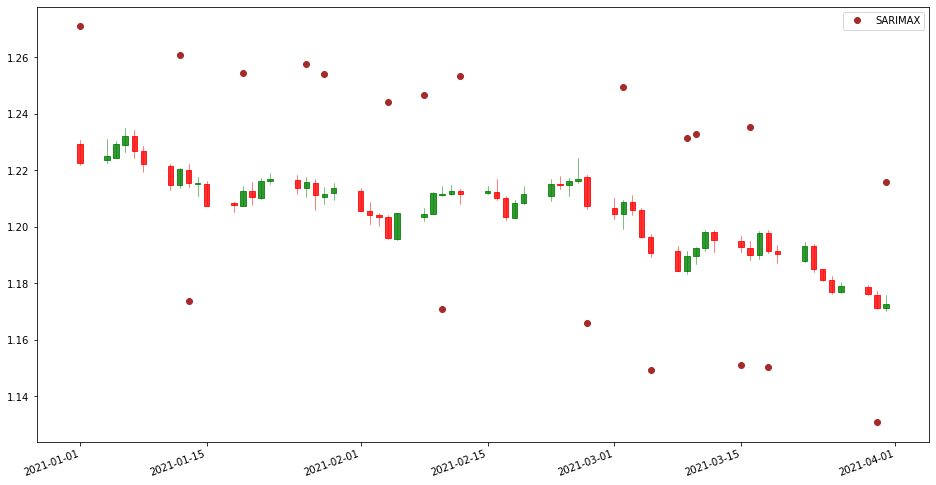

In [ ]:
#Setting
EU = EU1
DV = DV1
fig, ax = plt.subplots(figsize=(16, 8))

#plot Candle
candlestick_ohlc(ax, EU.values, width = 0.6,colorup = 'green', colordown = 'red',alpha = 0.8)

#plot Signal
ax.plot(DV.Date, DV.I, '^', label='Indicator',color = 'blue',)
ax.plot(DV.Date, DV.S, 'o', label='SARIMAX',color = 'brown',)
ax.plot(DV.Date, DV.IS, 's',label='Indicator + SARIMAX', color = 'orange',)

plt.xticks(rotation=20, ha='right')
ax.legend();

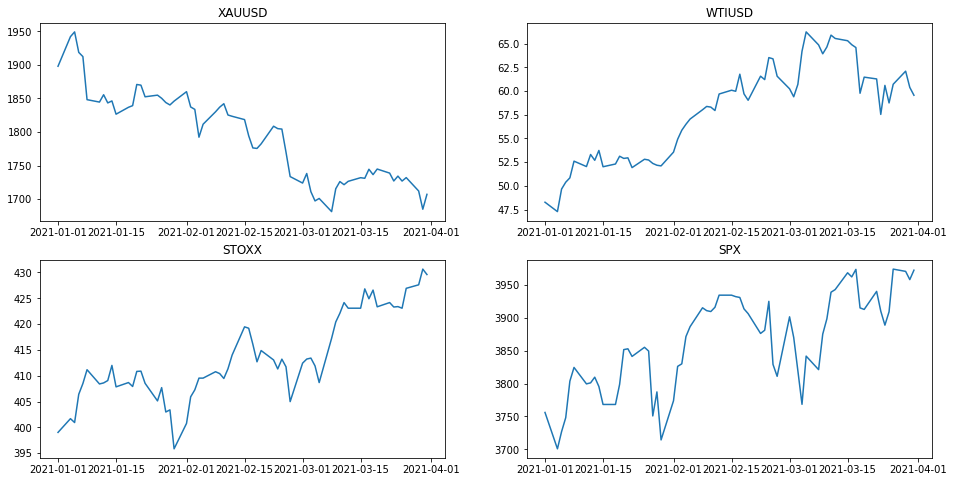

In [ ]:
#ตัวแปรอิสระ
figure, axis = plt.subplots(2, 2, figsize=(16, 8))
  
# For Sine Function
axis[0, 0].plot(XAUUSD['Date'][1566:1630],XAUUSD['Close'][1566:1630])
axis[0, 0].set_title("XAUUSD")
  
# For Cosine Function
axis[0, 1].plot(WTIUSD['Date'][1566:1630],WTIUSD['Close'][1566:1630])
axis[0, 1].set_title("WTIUSD")
  
# For Tangent Function
axis[1, 0].plot(STOXX['Date'][1566:1630],STOXX['Close'][1566:1630])
axis[1, 0].set_title("STOXX")
  
# For Tanh Function
axis[1, 1].plot(SPX['Date'][1566:1630],SPX['Close'][1566:1630])
axis[1, 1].set_title("SPX")
  
# Combine all the operations and display
plt.show()

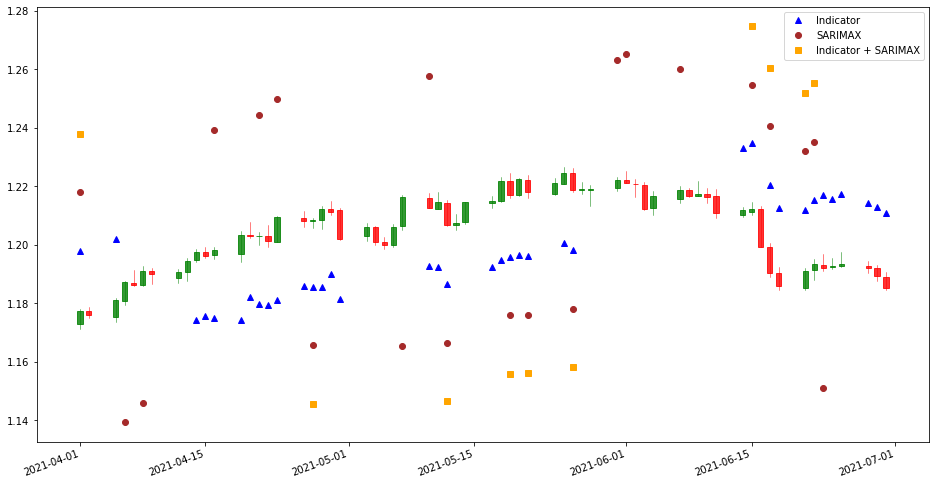

In [ ]:
#Setting
EU = EU2
DV = DV2
fig, ax = plt.subplots(figsize=(16, 8))

#plot Candle
candlestick_ohlc(ax, EU.values, width = 0.6,colorup = 'green', colordown = 'red',alpha = 0.8)

#plot Signal
ax.plot(DV.Date, DV.I, '^', label='Indicator',color = 'blue',)
ax.plot(DV.Date, DV.S, 'o', label='SARIMAX',color = 'brown',)
ax.plot(DV.Date, DV.IS, 's',label='Indicator + SARIMAX', color = 'orange',)

plt.xticks(rotation=20, ha='right')
ax.legend();

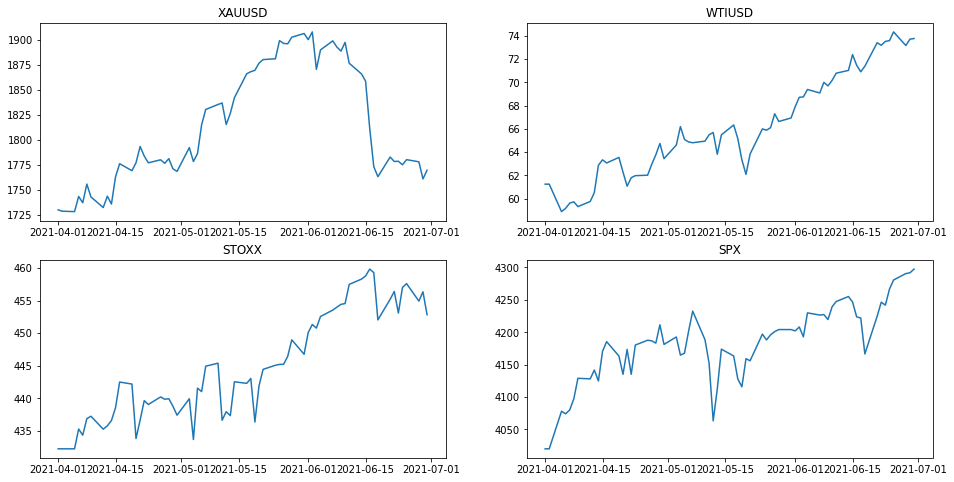

In [ ]:
#ตัวแปรอิสระ
figure, axis = plt.subplots(2, 2, figsize=(16, 8))
  
# For Sine Function
axis[0, 0].plot(XAUUSD['Date'][1630:1695],XAUUSD['Close'][1630:1695])
axis[0, 0].set_title("XAUUSD")
  
# For Cosine Function
axis[0, 1].plot(WTIUSD['Date'][1630:1695],WTIUSD['Close'][1630:1695])
axis[0, 1].set_title("WTIUSD")
  
# For Tangent Function
axis[1, 0].plot(STOXX['Date'][1630:1695],STOXX['Close'][1630:1695])
axis[1, 0].set_title("STOXX")
  
# For Tanh Function
axis[1, 1].plot(SPX['Date'][1630:1695],SPX['Close'][1630:1695])
axis[1, 1].set_title("SPX")
  
# Combine all the operations and display
plt.show()

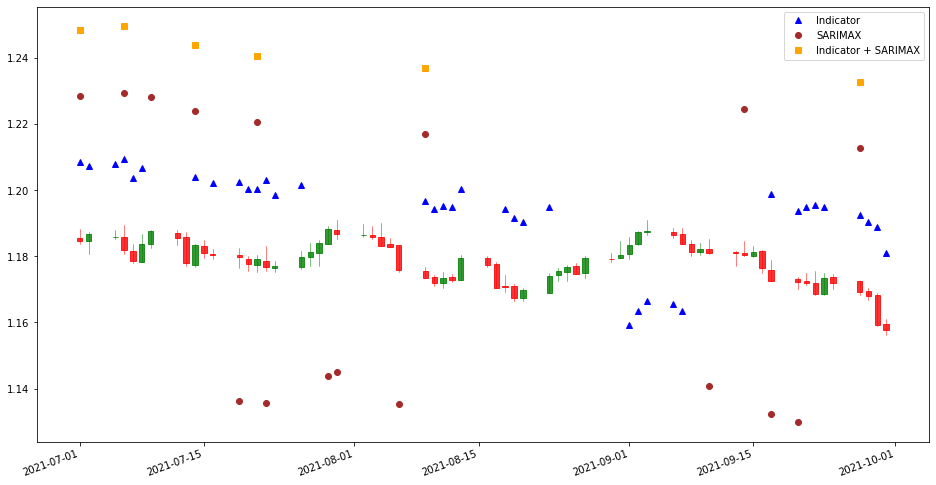

In [ ]:
#Setting
EU = EU3
DV = DV3
fig, ax = plt.subplots(figsize=(16, 8))

#plot Candle
candlestick_ohlc(ax, EU.values, width = 0.6,colorup = 'green', colordown = 'red',alpha = 0.8)

#plot Signal
ax.plot(DV.Date, DV.I, '^', label='Indicator',color = 'blue',)
ax.plot(DV.Date, DV.S, 'o', label='SARIMAX',color = 'brown',)
ax.plot(DV.Date, DV.IS, 's',label='Indicator + SARIMAX', color = 'orange',)

plt.xticks(rotation=20, ha='right')
ax.legend();

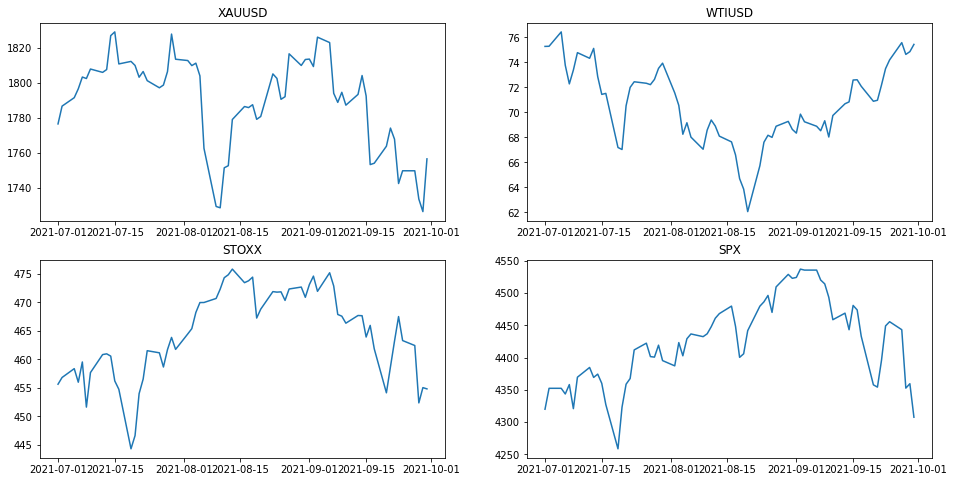

In [ ]:
#ตัวแปรอิสระ
figure, axis = plt.subplots(2, 2, figsize=(16, 8))
  
# For Sine Function
axis[0, 0].plot(XAUUSD['Date'][1695:1761],XAUUSD['Close'][1695:1761])
axis[0, 0].set_title("XAUUSD")
  
# For Cosine Function
axis[0, 1].plot(WTIUSD['Date'][1695:1761],WTIUSD['Close'][1695:1761])
axis[0, 1].set_title("WTIUSD")
  
# For Tangent Function
axis[1, 0].plot(STOXX['Date'][1695:1761],STOXX['Close'][1695:1761])
axis[1, 0].set_title("STOXX")
  
# For Tanh Function
axis[1, 1].plot(SPX['Date'][1695:1761],SPX['Close'][1695:1761])
axis[1, 1].set_title("SPX")
  
# Combine all the operations and display
plt.show()

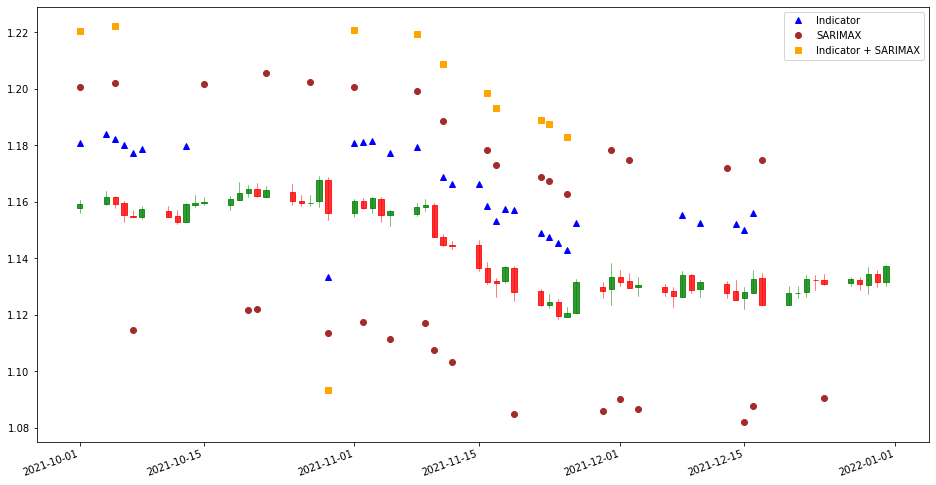

In [ ]:
#Setting
EU = EU4
DV = DV4
fig, ax = plt.subplots(figsize=(16, 8))

#plot Candle
candlestick_ohlc(ax, EU.values, width = 0.6,colorup = 'green', colordown = 'red',alpha = 0.8)

#plot Signal
ax.plot(DV.Date, DV.I, '^', label='Indicator',color = 'blue',)
ax.plot(DV.Date, DV.S, 'o', label='SARIMAX',color = 'brown',)
ax.plot(DV.Date, DV.IS, 's',label='Indicator + SARIMAX', color = 'orange',)

plt.xticks(rotation=20, ha='right')
ax.legend();

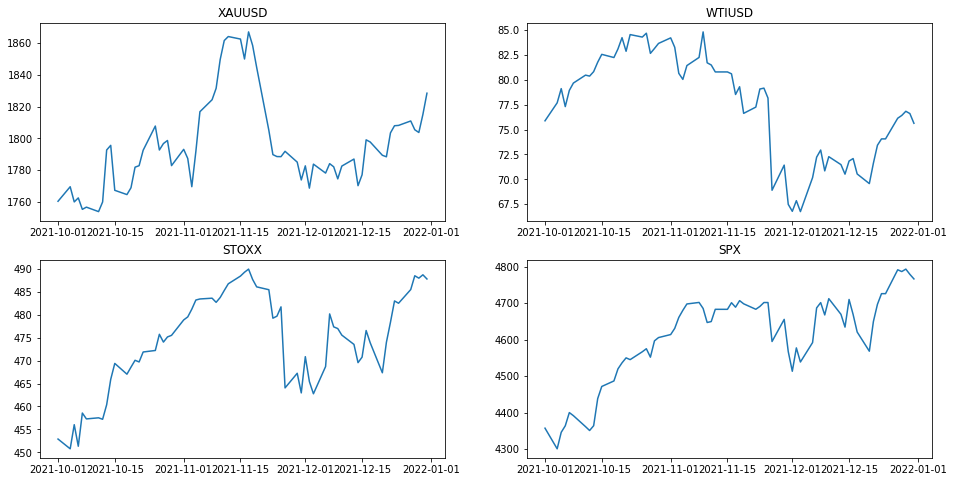

In [ ]:
#ตัวแปรอิสระ
figure, axis = plt.subplots(2, 2, figsize=(16, 8))
  
# For Sine Function
axis[0, 0].plot(XAUUSD['Date'][1761:],XAUUSD['Close'][1761:])
axis[0, 0].set_title("XAUUSD")
  
# For Cosine Function
axis[0, 1].plot(WTIUSD['Date'][1761:],WTIUSD['Close'][1761:])
axis[0, 1].set_title("WTIUSD")
  
# For Tangent Function
axis[1, 0].plot(STOXX['Date'][1761:],STOXX['Close'][1761:])
axis[1, 0].set_title("STOXX")
  
# For Tanh Function
axis[1, 1].plot(SPX['Date'][1761:],SPX['Close'][1761:])
axis[1, 1].set_title("SPX")
  
# Combine all the operations and display
plt.show()